In [505]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# IMPORT AND CLEAN THE DATA

### Airbnb data

In [506]:
# Import and clean airbnb data
airbnb_data = pd.read_csv("data/AB_NYC_2019.csv") # Read and transform the csv file to a pandas dataframe and assign it to a variable
print(airbnb_data.isna().sum()) # for each column check how many NaN values there are
print("------------------------")
airbnb_data = airbnb_data.drop(['name', "host_name", "last_review", "reviews_per_month"], axis=1)   # eliminate all columns not needed
airbnb_data = airbnb_data.rename(columns={"neighbourhood": "sub-borough", "neighbourhood_group": "borough"})    # rename columns
print(airbnb_data.isna().sum()) # for each column check how many NaN values there are again
airbnb_data.head(10)

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64
------------------------
id                                0
host_id                           0
borough                           0
sub-borough                       0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    

,id,host_id,borough,sub-borough,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
5,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129
6,5121,7356,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,1,0
7,5178,8967,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,1,220
8,5203,7490,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,1,0
9,5238,7549,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,4,188


### NYC map data

First we need to know the distribution of the city

In [507]:
# NYC Boroughs and sub-boroughs
bronx = ("Mott Haven", "Morrisania", "Highbridge", "University Heights", "Kingsbridge Heights",
         "Riverdale", "Soundview", "Throgs Neck", "Pelham Parkway", "Williamsbridge")

brooklyn = ("Williamsburg", "Bushwick", "Bedford Stuyvesant", "Brooklyn Heights", "Park Slope", "North Crown Heights",
            "South Crown Heights", "Brownsville", "East New York", "Flatlands", "East Flatbush", "Sunset Park", "Bay Ridge",
            "Borough Park", "Flatbush", "Sheepshead Bay", "Bensonhurst", "Coney Island")

manhattan = ("Greenwich Village", "Lower East Side", "Chelsea", "Stuyvesant Town", "Upper West Side", "Upper East Side",
             "Morningside Heights", "Central Harlem", "East Harlem", "Washington Heights")

queens = ("Astoria", "Long Island City", "Queensbridge", "Sunnyside", "Jackson Heights", "Elmhurst", "Middle Village", "Forest Hills",
          "Flushing", "Hillcrest", "Kew Gardens", "Howard Beach", "Bayside", "Bellerose", "Rego Park", "Ozone Park", "South Ozone Park", "Rockaways", "Jamaica", "Queens Village")

staten_island = ("North Shore", "Mid-Island", "South Shore")

For every sub-borough we make a column with the correspondant borough

In [508]:
nyc_map = gpd.read_file(geodatasets.get_path("geoda.nyc"))  # get the NYC map dataframe
nyc_map = nyc_map.drop(columns=['name'], inplace=False).drop(columns=['bor_subb'], inplace=False)   # eliminate columns not needed
nyc_map = nyc_map.rename(columns={"subborough": "sub-borough"}) # rename columns
borough = []    # list to save the boroughs of each sub-borough in the dataframe
for n in nyc_map['sub-borough']:
    neigh = n.split("/")[0]
    if neigh in queens:
        borough.append("Queens")
    elif neigh in staten_island:
        borough.append("Staten Island")
    elif neigh in manhattan:
        borough.append("Manhattan")
    elif neigh in brooklyn:
        borough.append("Brooklyn")
    elif neigh in bronx:
        borough.append("Bronx")
    else:
        print(f"{neigh}-Error")
nyc_map.insert(loc=1, column='borough', value=borough)  # add a column with the boroughs of every sub-borough
nyc_map

,code,borough,sub-borough,forhis06,forhis07,forhis08,forhis09,forwh06,forwh07,forwh08,...,rent2008,rentpct02,rentpct05,rentpct08,pubast90,pubast00,yrhom02,yrhom05,yrhom08,geometry
0,501,Staten Island,North Shore,37.0657,34.0317,27.3767,29.3091,13.2540,11.8768,11.1788,...,1000,21.1119,24.8073,28.5344,47.329128,6.005791,10.805068,12.127853,11.547433,"POLYGON ((962498.866 175588.946, 962914.98 175..."
1,502,Staten Island,Mid-Island,27.9822,18.1193,24.0452,31.1566,20.0616,19.8575,22.4870,...,950,32.3615,27.2584,27.9567,35.182323,2.287034,15.241246,15.183111,14.682124,"MULTIPOLYGON (((928296.856 163214.206, 928736...."
2,503,Staten Island,South Shore,10.7019,12.1404,9.6890,14.6638,10.3060,12.7699,9.3561,...,800,23.0547,20.4146,18.1590,23.894043,1.350208,12.704250,12.972280,13.561487,"MULTIPOLYGON (((932416.259 149575.995, 933217...."
3,401,Queens,Astoria,52.0961,53.9585,54.6968,47.8050,38.3658,35.6551,32.1289,...,1400,25.6022,26.7685,28.0467,80.533928,5.204510,12.839167,13.377513,12.544640,"MULTIPOLYGON (((1010873.21 226064.189, 1010878..."
4,402,Queens,Sunnyside/Woodside,62.7242,69.3969,67.0897,58.2963,37.0512,31.9057,32.3264,...,1400,18.8079,22.6752,21.3009,75.516866,2.974139,15.387656,12.518789,12.666909,"POLYGON ((1011646.607 216285.604, 1011729.063 ..."
5,403,Queens,Jackson Heights,68.4834,68.5405,66.5080,69.1580,34.3999,38.2428,38.1470,...,1100,34.0156,34.8050,27.1032,66.642281,5.332569,12.649229,12.580355,11.965980,"MULTIPOLYGON (((1014789.93 220797.982, 1014622..."
6,404,Queens,Elmhurst/Corona,69.5219,66.8795,69.3414,64.3005,40.3935,51.6376,45.9578,...,1300,26.7381,34.3842,28.8255,77.530801,6.029230,11.554984,9.828084,10.738053,"MULTIPOLYGON (((1018353.243 205630.094, 101829..."
7,405,Queens,Middle Village/Ridgewood,39.4185,35.9546,36.2750,35.0181,37.8097,34.0156,33.0695,...,1100,41.2035,40.6256,36.2956,59.017019,3.951290,13.498408,12.616178,11.191645,"POLYGON ((1013477.142 206918.569, 1013729.105 ..."
8,406,Queens,Rego Park/Forest Hills,58.5388,52.6183,42.3878,47.9795,43.7395,47.5873,45.1205,...,1400,11.9766,10.4943,11.5520,64.162134,3.111417,13.401562,13.375477,12.742296,"POLYGON ((1026974.169 207617.321, 1027033.301 ..."
9,407,Queens,Flushing/Whitestone,59.4432,53.4747,53.2531,57.9868,26.5802,25.6864,21.3858,...,1200,23.9394,23.3487,22.6715,53.629649,2.795721,14.011260,12.806067,12.848001,"POLYGON ((1034250.672 230784.278, 1036136.389 ..."


For every borough we make a column with the amount of listings in that zone

In [509]:
# Import and clean nyc map data
borough_counter = airbnb_data['borough'].value_counts() # count the number of listings in that borough
borough_listings = []   # list that will save in orden de number of listings in the same borough as the instance in the dataframe
for com in nyc_map["borough"]:
    if com == "Manhattan":
        borough_listings.append(borough_counter["Manhattan"])
    elif com == "Bronx":
        borough_listings.append(borough_counter["Bronx"])
    elif com == "Queens":
        borough_listings.append(borough_counter["Queens"])
    elif com == "Staten Island":
        borough_listings.append(borough_counter["Staten Island"])
    elif com == "Brooklyn":
        borough_listings.append(borough_counter["Brooklyn"])
    else:
        print("Error")
nyc_map.insert(loc=0, column='borough_listings', value=borough_listings)    # add the number of listings in the same borough as a column
nyc_map

,borough_listings,code,borough,sub-borough,forhis06,forhis07,forhis08,forhis09,forwh06,forwh07,...,rent2008,rentpct02,rentpct05,rentpct08,pubast90,pubast00,yrhom02,yrhom05,yrhom08,geometry
0,373,501,Staten Island,North Shore,37.0657,34.0317,27.3767,29.3091,13.2540,11.8768,...,1000,21.1119,24.8073,28.5344,47.329128,6.005791,10.805068,12.127853,11.547433,"POLYGON ((962498.866 175588.946, 962914.98 175..."
1,373,502,Staten Island,Mid-Island,27.9822,18.1193,24.0452,31.1566,20.0616,19.8575,...,950,32.3615,27.2584,27.9567,35.182323,2.287034,15.241246,15.183111,14.682124,"MULTIPOLYGON (((928296.856 163214.206, 928736...."
2,373,503,Staten Island,South Shore,10.7019,12.1404,9.6890,14.6638,10.3060,12.7699,...,800,23.0547,20.4146,18.1590,23.894043,1.350208,12.704250,12.972280,13.561487,"MULTIPOLYGON (((932416.259 149575.995, 933217...."
3,5666,401,Queens,Astoria,52.0961,53.9585,54.6968,47.8050,38.3658,35.6551,...,1400,25.6022,26.7685,28.0467,80.533928,5.204510,12.839167,13.377513,12.544640,"MULTIPOLYGON (((1010873.21 226064.189, 1010878..."
4,5666,402,Queens,Sunnyside/Woodside,62.7242,69.3969,67.0897,58.2963,37.0512,31.9057,...,1400,18.8079,22.6752,21.3009,75.516866,2.974139,15.387656,12.518789,12.666909,"POLYGON ((1011646.607 216285.604, 1011729.063 ..."
5,5666,403,Queens,Jackson Heights,68.4834,68.5405,66.5080,69.1580,34.3999,38.2428,...,1100,34.0156,34.8050,27.1032,66.642281,5.332569,12.649229,12.580355,11.965980,"MULTIPOLYGON (((1014789.93 220797.982, 1014622..."
6,5666,404,Queens,Elmhurst/Corona,69.5219,66.8795,69.3414,64.3005,40.3935,51.6376,...,1300,26.7381,34.3842,28.8255,77.530801,6.029230,11.554984,9.828084,10.738053,"MULTIPOLYGON (((1018353.243 205630.094, 101829..."
7,5666,405,Queens,Middle Village/Ridgewood,39.4185,35.9546,36.2750,35.0181,37.8097,34.0156,...,1100,41.2035,40.6256,36.2956,59.017019,3.951290,13.498408,12.616178,11.191645,"POLYGON ((1013477.142 206918.569, 1013729.105 ..."
8,5666,406,Queens,Rego Park/Forest Hills,58.5388,52.6183,42.3878,47.9795,43.7395,47.5873,...,1400,11.9766,10.4943,11.5520,64.162134,3.111417,13.401562,13.375477,12.742296,"POLYGON ((1026974.169 207617.321, 1027033.301 ..."
9,5666,407,Queens,Flushing/Whitestone,59.4432,53.4747,53.2531,57.9868,26.5802,25.6864,...,1200,23.9394,23.3487,22.6715,53.629649,2.795721,14.011260,12.806067,12.848001,"POLYGON ((1034250.672 230784.278, 1036136.389 ..."


# DATA ANALYSIS

### Overall analysis

Text(0.5, 1.0, 'Prices of Airbnbs in NYC')

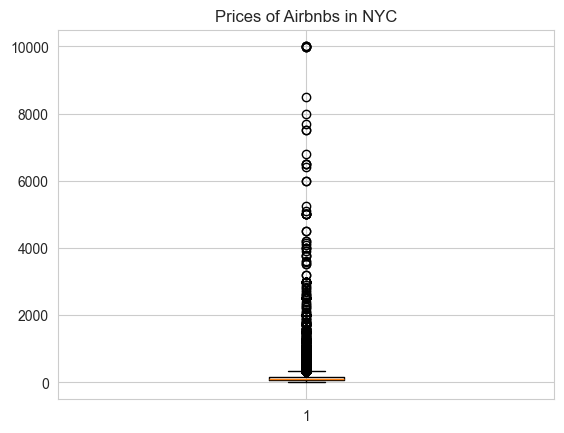

In [510]:
plt.boxplot(x=airbnb_data['price'])
plt.title('Prices of Airbnbs in NYC')

The numerous outliers indicate that some of these listings are exceptionally luxurious, which is unsurprising given that NYC boasts the [highest number of ultra-high-net-worth individuals](https://spearswms.com/wealth/where-do-the-super-rich-live-worlds-wealthiest-cities-in-2024-revealed/) than any other city in the world as of 2024. Let's see how the boxplot changes once we ignore the outliers.

Text(0.5, 1.0, 'Prices of Airbnbs in NYC')

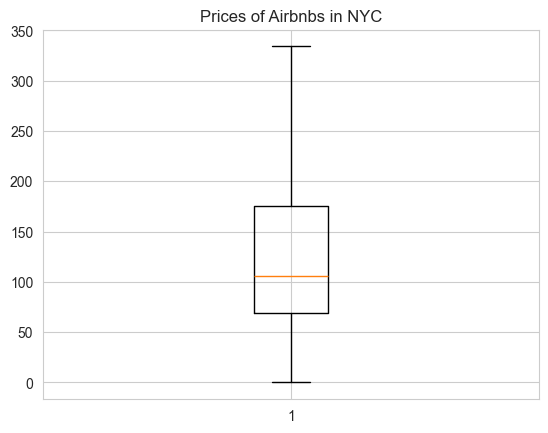

In [511]:
plt.boxplot(x=airbnb_data['price'], showfliers=False)
plt.title('Prices of Airbnbs in NYC')

As we can see, once we have ignored the outliers, most of the prices are between 70 dollars and 180 dollars. Let's see de distribution of prices

Standard deviation of prices: $240.15


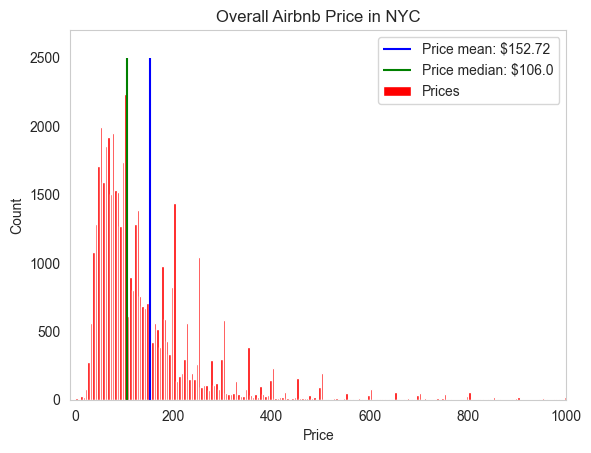

In [512]:
overall_price_mean = round(airbnb_data.price.mean(), 2) # calculate the mean
overall_price_median = round(airbnb_data.price.median(), 2) # calculate the median
overall_price_std = round(airbnb_data.price.std(), 2)   # calculate the standard deviation

plt.hist(airbnb_data.price, bins=2000, color="red") # create the histogram   
plt.vlines(x=overall_price_mean, ymin=0, ymax=2500, color="blue")   # draw the vertical mean line
plt.vlines(x=overall_price_median, ymin=0, ymax=2500, color="green")    # draw the vertical median line
plt.title("Overall Airbnb Price in NYC")    
plt.xlabel("Price")
plt.ylabel("Count")
plt.legend([f"Price mean: ${overall_price_mean}", f"Price median: ${overall_price_median}", "Prices"])
plt.xlim([-10, 1000])
plt.ylim([0, 2700])
plt.grid()
print(f"Standard deviation of prices: ${overall_price_std}")

We can see in more detail how the prices changes, this indicates that New York City is a costly place to stay in an Airbnb, likely due to the high demand for real estate and the [limited availability of properties](https://comptroller.nyc.gov/reports/spotlight-new-york-citys-housing-supply-challenge/). However, the high standard deviation indicates significant variability in prices. This fluctuation is likely influenced by location, as it's reasonable to expect that areas like Manhattan and Bronx would have distinctly different pricing which we will be analyzing in the future.

### Analysis based on boroughs

Text(0.5, 1.0, 'Number of listings by borough')

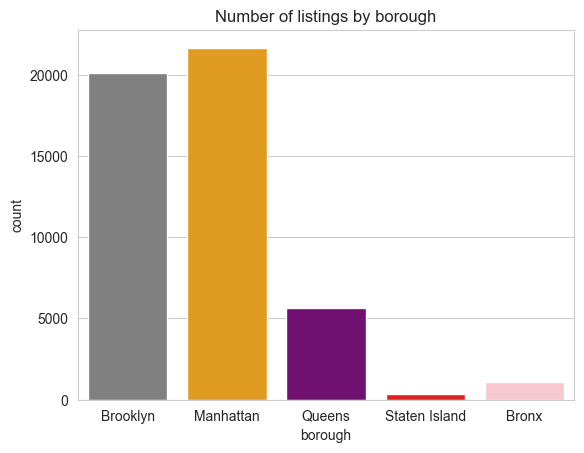

In [513]:
number_of_different_neighbourhood_groups = airbnb_data['borough'].value_counts()
sns.countplot(data=airbnb_data, x="borough", hue="borough", palette=['grey', 'orange', 'purple', "red", "pink"], legend=False)
plt.title("Number of listings by borough")

As we can see, Manhattan and Brooklyn have the highest number of listings, suggesting strong demand in these boroughs. It’s also likely that the most expensive Airbnbs are concentrated in these areas, especially in Manhattan. Let's see a heat map

<Axes: title={'center': 'Airbnb Listings per Boroughs in NYC'}, xlabel='Longitude', ylabel='Latitude'>

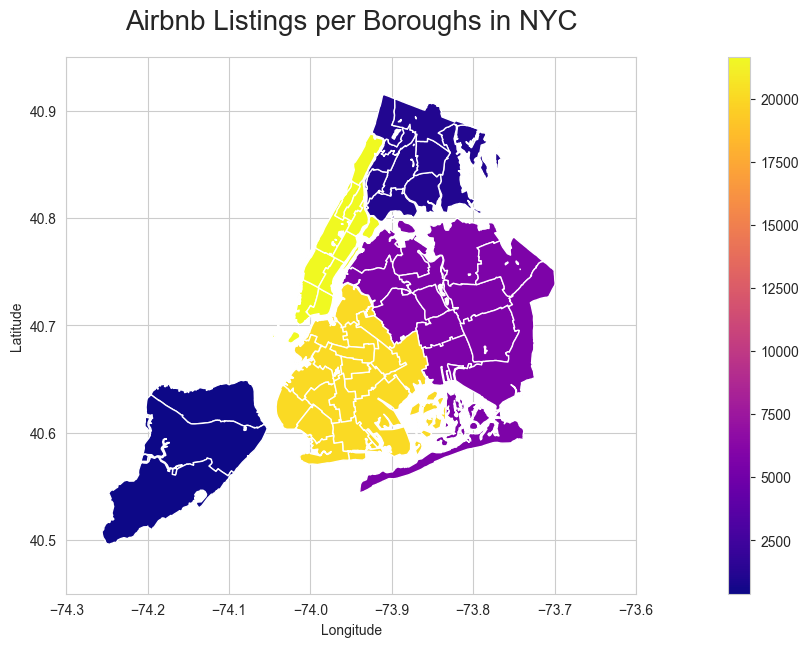

In [514]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nyc_map = nyc_map.to_crs(epsg=4326) # change axis to coordinates
ax.set_xlim([-74.3, -73.6])
ax.set_ylim([40.45, 40.95])  
ax.set_title('Airbnb Listings per Boroughs in NYC', pad=20, fontdict={'fontsize': 20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
nyc_map.plot(ax=ax, cax=cax, cmap="plasma", column="borough_listings", legend=True)

<Axes: title={'center': 'Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

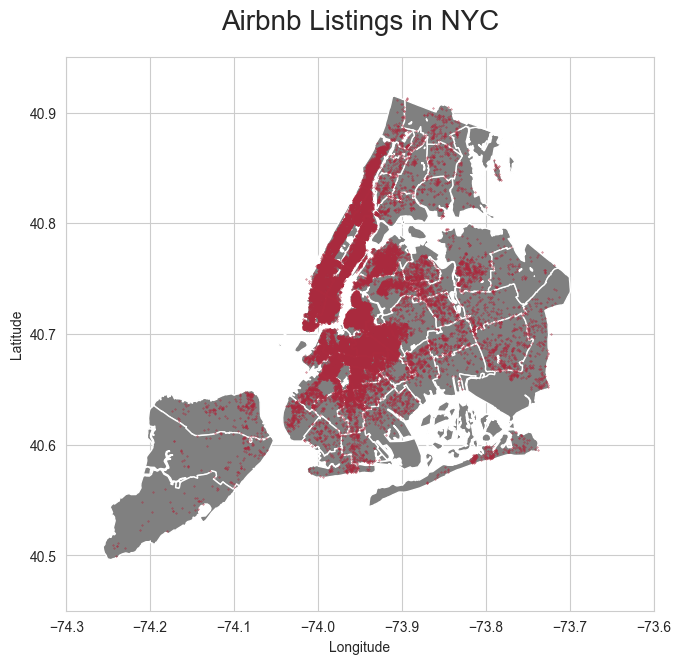

In [515]:
points = airbnb_data[['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(points['longitude'], points['latitude'])]   # create object Points
nyc_airbnb = gpd.GeoDataFrame(points, geometry=geometry)    # create dataframe with Points
nyc_airbnb.set_crs(epsg=4326, inplace=True)  # CRS standard for coordinates
nyc_airbnb = nyc_airbnb.to_crs(epsg=4326)   # change map axis to coordinates
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 10))
ax.axis([-74.3, -73.6, 40.45, 40.95])
ax.set_title('Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
nyc_map.plot(ax=ax, figsize=(10, 10), color="grey")
nyc_airbnb.plot(ax=ax, marker='o', color='#AB2A3E', markersize=0.1)

In this last map we can clearly see how high are the number of listings in Manhattan and Brooklyn compared to the others.

Text(0.5, 1.0, 'Prices of Boroughs in NYC')

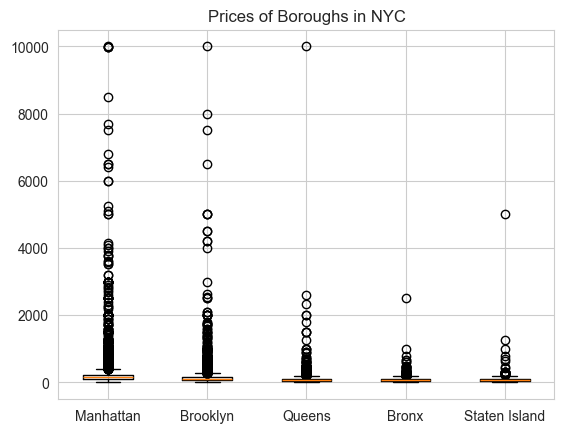

In [516]:
Manhattan_price_data = airbnb_data.loc[airbnb_data['borough'] == 'Manhattan', 'price']
Brooklyn_price_data = airbnb_data.loc[airbnb_data['borough'] == 'Brooklyn', 'price']
Bronx_price_data = airbnb_data.loc[airbnb_data['borough'] == 'Bronx', 'price']
Queens_price_data = airbnb_data.loc[airbnb_data['borough'] == 'Queens', 'price']
Staten_island_price_data = airbnb_data.loc[airbnb_data['borough'] == 'Staten Island', 'price']

plt.boxplot(x=[Manhattan_price_data, Brooklyn_price_data, Queens_price_data, Bronx_price_data, Staten_island_price_data], 
            labels=['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
plt.title('Prices of Boroughs in NYC')

We can observe that there are a lot of outliers on every borough which can affect tremendously the mean value of the price in that zone, for that reason I will take into acount the most repeated price in every borough instead of the mean, let's take a look into it ignoring the outliers

Text(0.5, 1.0, 'Prices of Boroughs in NYC')

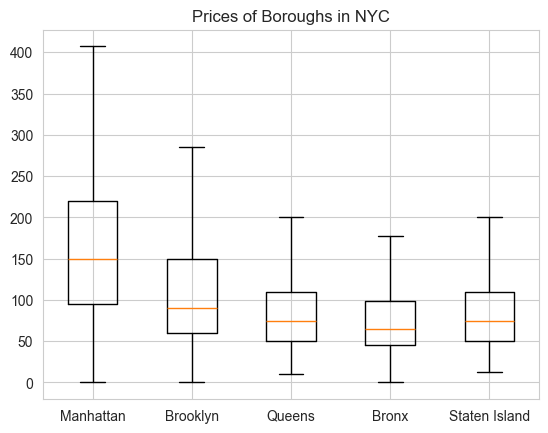

In [517]:
plt.boxplot(x=[Manhattan_price_data, Brooklyn_price_data, Queens_price_data, Bronx_price_data, Staten_island_price_data], 
            labels=['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'], showfliers=False)
plt.title('Prices of Boroughs in NYC')

Now we can clearly see that Manhattan is the most expensive borough, followed by Brooklyn, Queens, Staten Island and lastly Bronx. 

#### MANHATTAN ANALYSIS
Since Manhattan has the most expensive airbnbs, let's see where are they located. First the luxury ones, which are between 500-5000 dollars

In [518]:
# Prepare manhattan map
manhattan_map = nyc_map[nyc_map['borough'] == "Manhattan"].to_crs(epsg=4326)    # select and change manhattan map to coordinates
manhattan_map.drop(['borough', 'code', 'borough_listings'], axis=1, inplace=True)   # eliminate columns

<Axes: title={'center': 'Manhattan Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

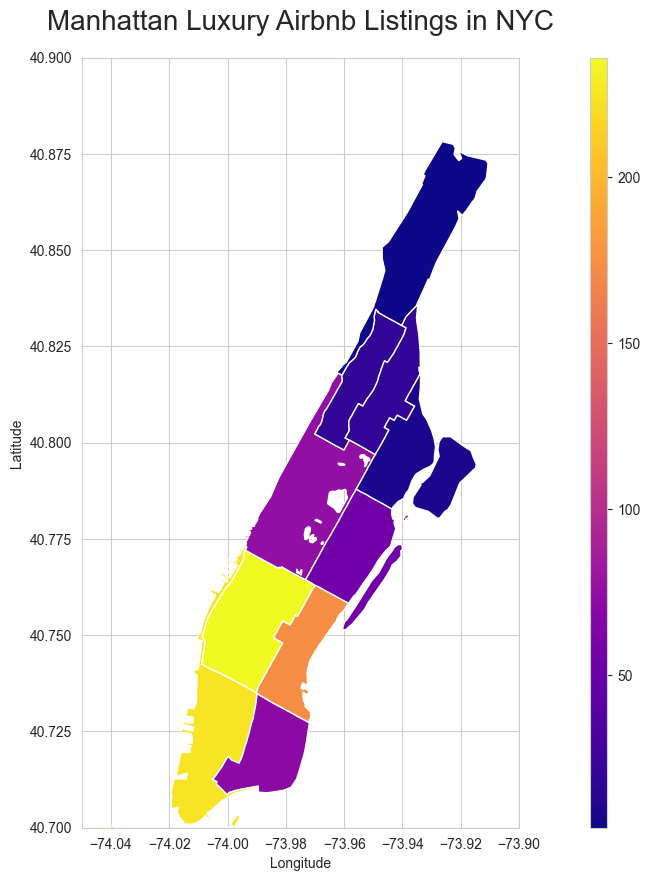

In [519]:
# Preparing the data
manhattan_luxury_coordinates = airbnb_data.loc[(airbnb_data['price'] >= 500) & (airbnb_data['price'] <= 5000), 
                                              ['latitude', 'longitude']]    # filter of luxury listings
geometry = [Point(xy) for xy in zip(manhattan_luxury_coordinates['longitude'], manhattan_luxury_coordinates['latitude'])]   # create objects Point
manhattan_airbnb = gpd.GeoDataFrame(manhattan_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)   # create data frame with Points
luxury_listings_in_manhattan = gpd.sjoin(manhattan_airbnb, manhattan_map, how='inner')  # merge both dataframes
luxury_listings_in_manhattan = luxury_listings_in_manhattan["index_right"].value_counts()   # count how many points are in every sub-borough
manhattan_map.insert(loc=0, column='luxury_listings', value=luxury_listings_in_manhattan)   # add new column to manhattan map
manhattan_map = manhattan_map.fillna(0) # change default missing values from NaN to 0

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.9])
ax.set_ylim([40.7, 40.9])
ax.set_title('Manhattan Luxury Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
manhattan_map.plot(ax=ax, cax=cax, cmap="plasma", column="luxury_listings", legend=True)

As we can clearly see, the most amount of luxury properties are in Midtown, specifically in the West zone(Hell's Kitchen, Chelsea, etc.) and in the Financial District. Now, let's see where are the ultra-luxury properties in manhattan, which cost more than 5000 dollars per night

<Axes: title={'center': 'Manhattan Ultra-Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

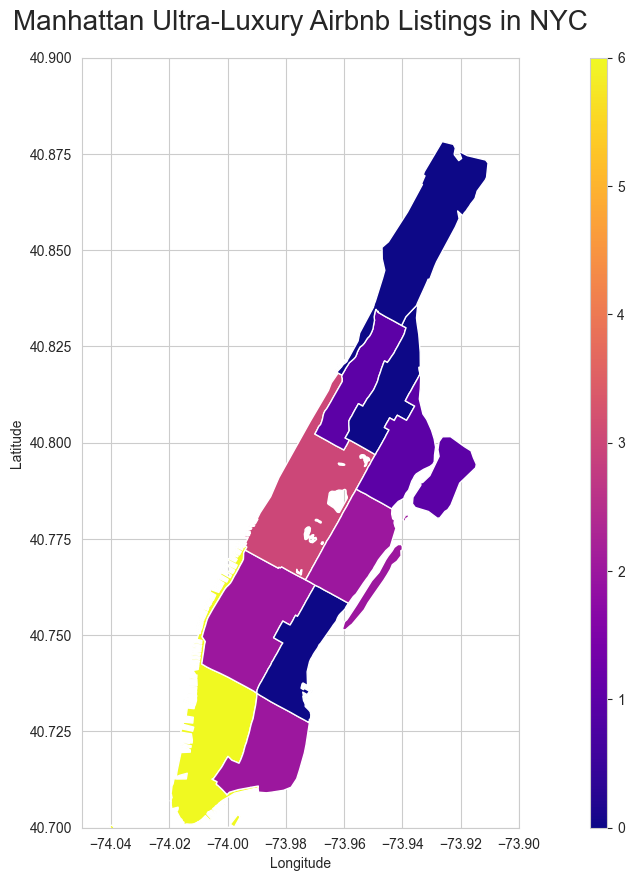

In [520]:
# Preparing the data
manhattan_luxury_coordinates = airbnb_data.loc[airbnb_data['price'] >= 5000, 
                                              ['latitude', 'longitude']]    # filter
geometry = [Point(xy) for xy in zip(manhattan_luxury_coordinates['longitude'], manhattan_luxury_coordinates['latitude'])]   # make Points objects
manhattan_airbnb = gpd.GeoDataFrame(manhattan_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)   # create data frame for Points
ultra_luxury_listings_in_manhattan = gpd.sjoin(manhattan_airbnb, manhattan_map, how='inner')  
ultra_luxury_listings_in_manhattan = ultra_luxury_listings_in_manhattan["index_right"].value_counts()
manhattan_map.insert(loc=0, column='ultra_luxury_listings', value=ultra_luxury_listings_in_manhattan)
manhattan_map = manhattan_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.9])
ax.set_ylim([40.7, 40.9])
ax.set_title('Manhattan Ultra-Luxury Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
manhattan_map.plot(ax=ax, cax=cax, cmap="plasma", column="ultra_luxury_listings", legend=True)

Let's now see where are the different types of listings based on room type

Text(0, 0.5, 'Number of Listings')

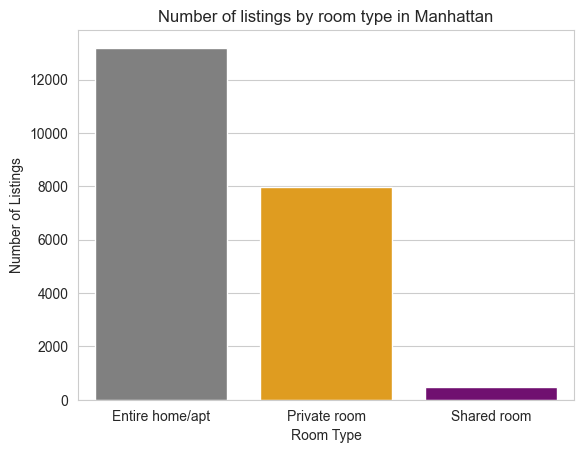

In [521]:
number_type_rooms_manhattan = airbnb_data.loc[airbnb_data['borough'] == 'Manhattan', 'room_type']
count_type_rooms_manhattan = number_type_rooms_manhattan.value_counts().reset_index()
count_type_rooms_manhattan.columns = ['room_type', 'count']

sns.barplot(data=count_type_rooms_manhattan, x='room_type', y='count', hue='room_type', palette=['grey', 'orange', 'purple'])
plt.title("Number of listings by room type in Manhattan")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")

Let's see now how the prices changes between types of rooms

Text(0.5, 1.0, 'Prices by types of rooms in Manhattan')

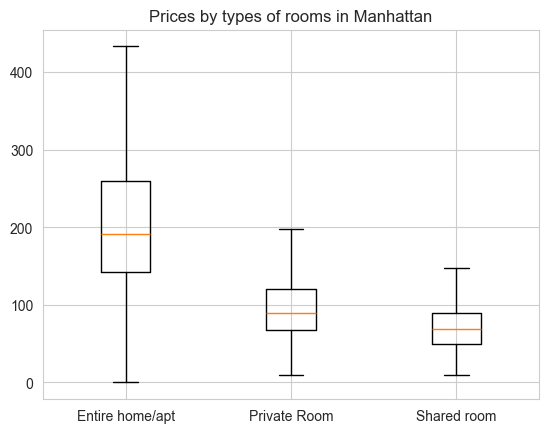

In [522]:
boxplot_homes_manhattan = airbnb_data.loc[(airbnb_data['borough'] == 'Manhattan') & (airbnb_data['room_type'] == 'Entire home/apt'), 'price']
boxplot_private_room_manhattan = airbnb_data.loc[(airbnb_data['borough'] == 'Manhattan') & (airbnb_data['room_type'] == 'Private room'), 'price']
boxplot_shared_room_manhattan = airbnb_data.loc[(airbnb_data['borough'] == 'Manhattan') & (airbnb_data['room_type'] == 'Shared room'), 'price']
plt.boxplot(x=[boxplot_homes_manhattan, boxplot_private_room_manhattan, boxplot_shared_room_manhattan], 
            labels=["Entire home/apt", "Private Room", "Shared room"], showfliers=False)
plt.title('Prices by types of rooms in Manhattan')

We can see that entire homes or apartments cost from 150 dollars - 260 dollars, the private rooms around 70 dollars - 110 dollars and shared rooms around 50 dollars - 90 dollars. Let's now see where are the cheapest apartments in manhattan

<Axes: title={'center': 'Manhattan Cheapest Entire Homes Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

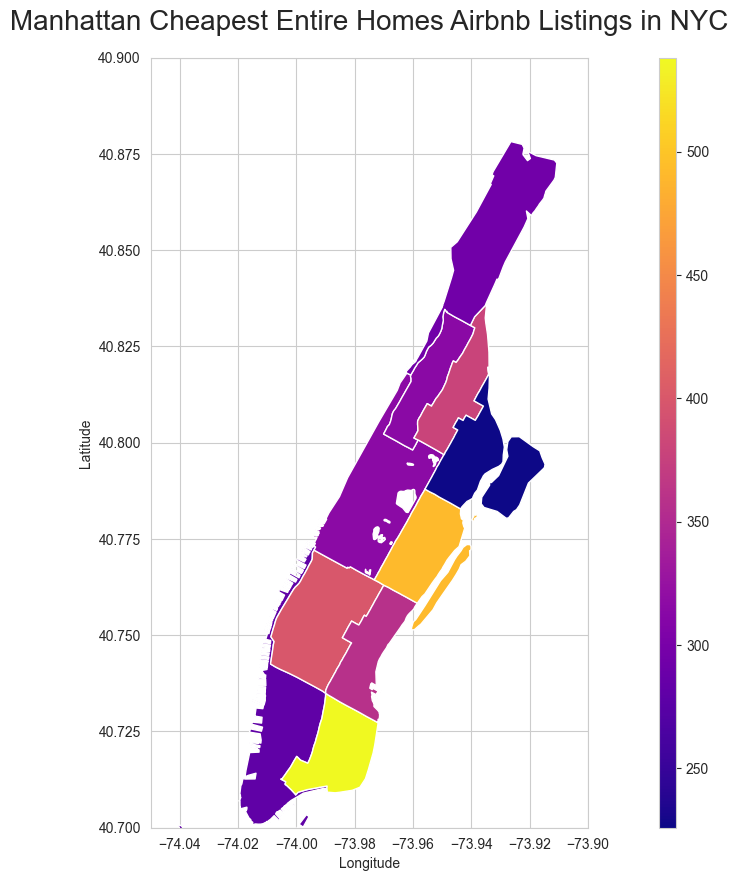

In [523]:
# Preparing the data
manhattan_cheap_entire_apt_coordinates = airbnb_data.loc[(airbnb_data['price'] < 150) & (airbnb_data['room_type'] == 'Entire home/apt'), 
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(manhattan_cheap_entire_apt_coordinates['longitude'], manhattan_cheap_entire_apt_coordinates['latitude'])]
manhattan_cheap_entire_apt_airbnb = gpd.GeoDataFrame(manhattan_cheap_entire_apt_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_entire_apt_listings_in_manhattan = gpd.sjoin(manhattan_cheap_entire_apt_airbnb, manhattan_map, how='inner')
cheap_entire_apt_listings_in_manhattan = cheap_entire_apt_listings_in_manhattan["index_right"].value_counts()
manhattan_map.insert(loc=0, column='cheap_entire_apt_listings', value=cheap_entire_apt_listings_in_manhattan)
manhattan_map = manhattan_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.9])
ax.set_ylim([40.7, 40.9])
ax.set_title('Manhattan Cheapest Entire Homes Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
manhattan_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_entire_apt_listings", legend=True)

As we can clearly see, the cheapest entire apartments are in Lower East Side and East Village, followed by East Midtown and Murray Hill

<Axes: title={'center': 'Manhattan Cheapest Private Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

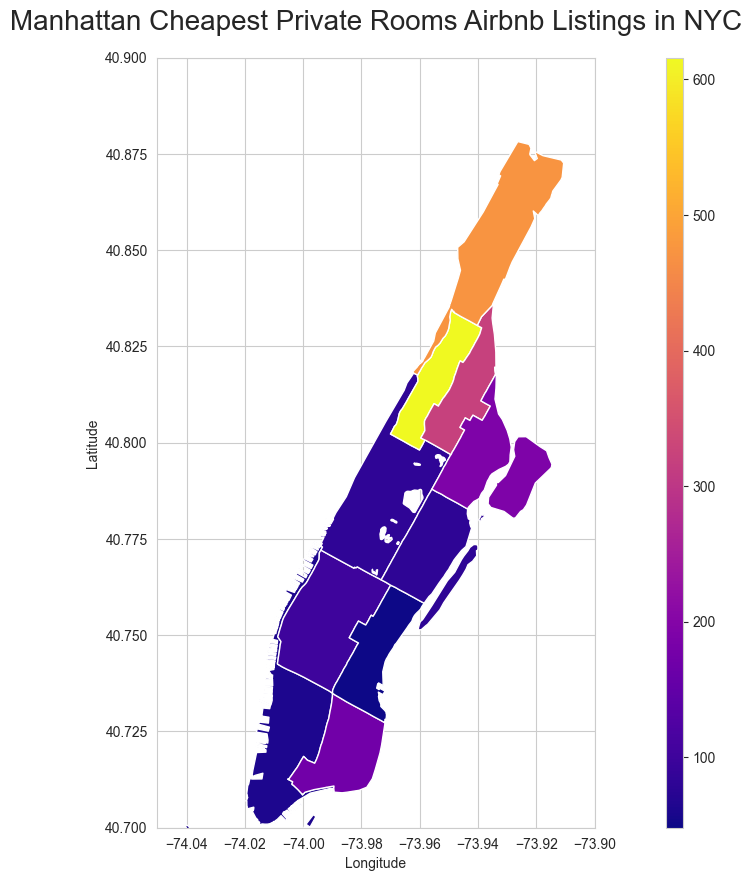

In [524]:
# Preparing the data
manhattan_cheap_private_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 70) & (airbnb_data['room_type'] == 'Private room'), 
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(manhattan_cheap_private_room_coordinates['longitude'], manhattan_cheap_private_room_coordinates['latitude'])]
manhattan_cheap_private_room_airbnb = gpd.GeoDataFrame(manhattan_cheap_private_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_private_room_listings_in_manhattan = gpd.sjoin(manhattan_cheap_private_room_airbnb, manhattan_map, how='inner')
cheap_private_room_listings_in_manhattan = cheap_private_room_listings_in_manhattan["index_right"].value_counts()
manhattan_map.insert(loc=0, column='cheap_private_room_listings', value=cheap_private_room_listings_in_manhattan)
manhattan_map = manhattan_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.9])
ax.set_ylim([40.7, 40.9])
ax.set_title('Manhattan Cheapest Private Rooms Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
manhattan_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_private_room_listings", legend=True)

As we can see, regarding the private rooms, cheapest zones are Hamilton Heights and Morningside Heights.

<Axes: title={'center': 'Manhattan Cheapest Shared Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

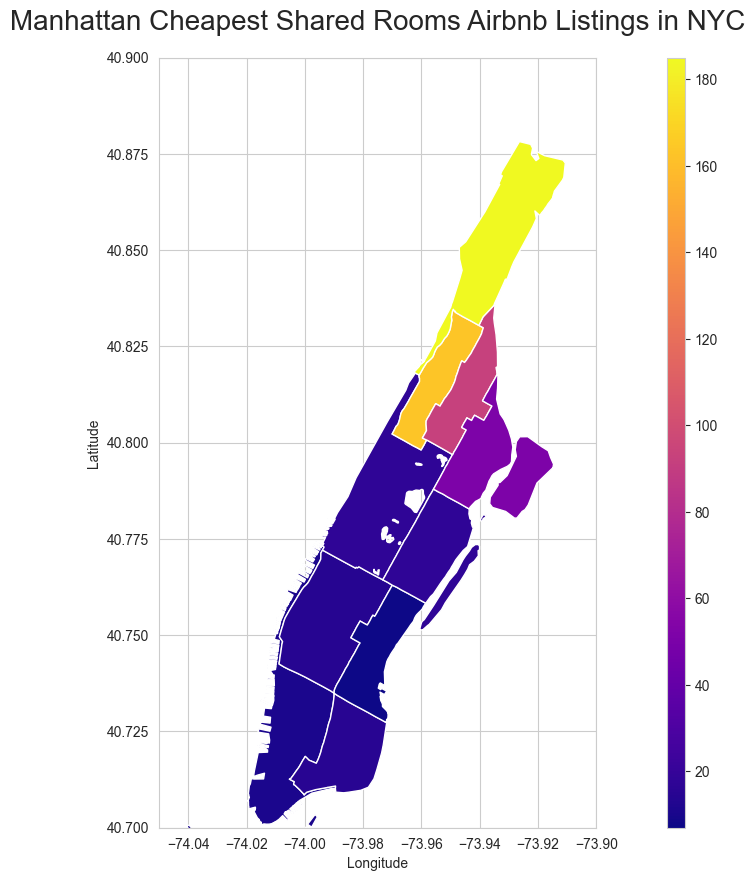

In [525]:
# Preparing the data
manhattan_cheap_shared_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 50) & (airbnb_data['room_type'] == 'Private room'), 
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(manhattan_cheap_shared_room_coordinates['longitude'], manhattan_cheap_shared_room_coordinates['latitude'])]
manhattan_cheap_shared_room_airbnb = gpd.GeoDataFrame(manhattan_cheap_shared_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_shared_room_listings_in_manhattan = gpd.sjoin(manhattan_cheap_shared_room_airbnb, manhattan_map, how='inner')
cheap_shared_room_listings_in_manhattan = cheap_shared_room_listings_in_manhattan["index_right"].value_counts()
manhattan_map.insert(loc=0, column='cheap_shared_room_listings', value=cheap_shared_room_listings_in_manhattan)
manhattan_map = manhattan_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.9])
ax.set_ylim([40.7, 40.9])
ax.set_title('Manhattan Cheapest Shared Rooms Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
manhattan_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_shared_room_listings", legend=True)

As we can clearly see, the cheapest shared rooms are in Way Uptown Manhattan and Morningside Heights.

#### BROOKLYN ANALYSIS
The borough with the most amount of luxury properties is Brooklyn, so let's analyze this

In [526]:
# Prepare the map
brooklyn_map = nyc_map[nyc_map['borough'] == "Brooklyn"].to_crs(epsg=4326)
brooklyn_map.drop(['borough', 'code', 'borough_listings'], axis=1, inplace=True)

<Axes: title={'center': 'Brooklyn Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

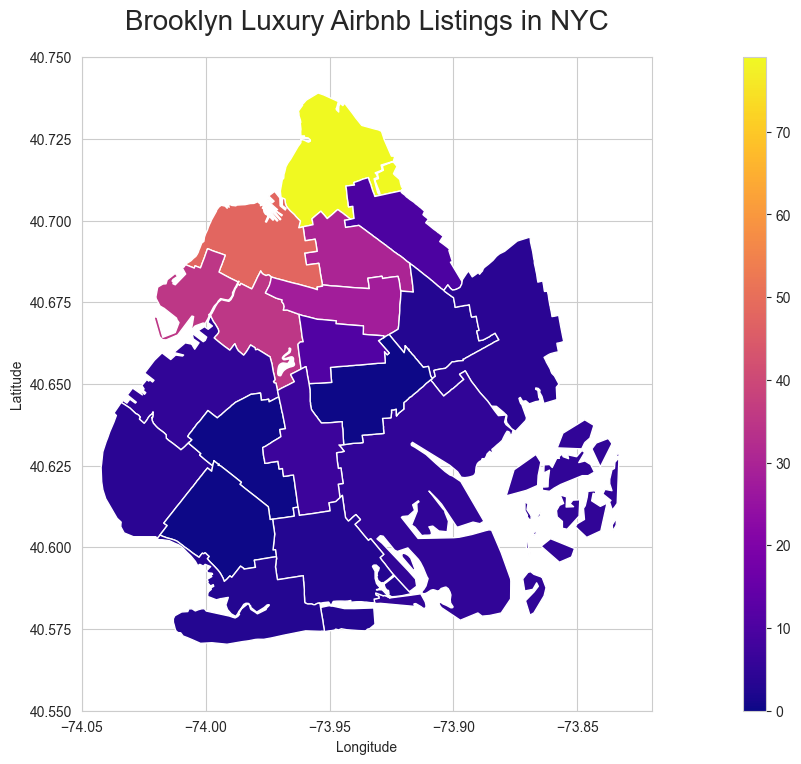

In [527]:
# Preparing the data
brooklyn_luxury_coordinates = airbnb_data.loc[(airbnb_data['price'] >= 500) & (airbnb_data['price'] <= 5000), 
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(brooklyn_luxury_coordinates['longitude'], brooklyn_luxury_coordinates['latitude'])]
brooklyn_airbnb = gpd.GeoDataFrame(brooklyn_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
luxury_listings_in_brooklyn = gpd.sjoin(brooklyn_airbnb, brooklyn_map, how='inner')
luxury_listings_in_brooklyn = luxury_listings_in_brooklyn["index_right"].value_counts()
brooklyn_map.insert(loc=0, column='luxury_listings', value=luxury_listings_in_brooklyn)
brooklyn_map = brooklyn_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.82])  
ax.set_ylim([40.55, 40.75])
ax.set_title('Brooklyn Luxury Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
brooklyn_map.plot(ax=ax, cax=cax, cmap="plasma", column="luxury_listings", legend=True)

<Axes: title={'center': 'Brooklyn Ultra-Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

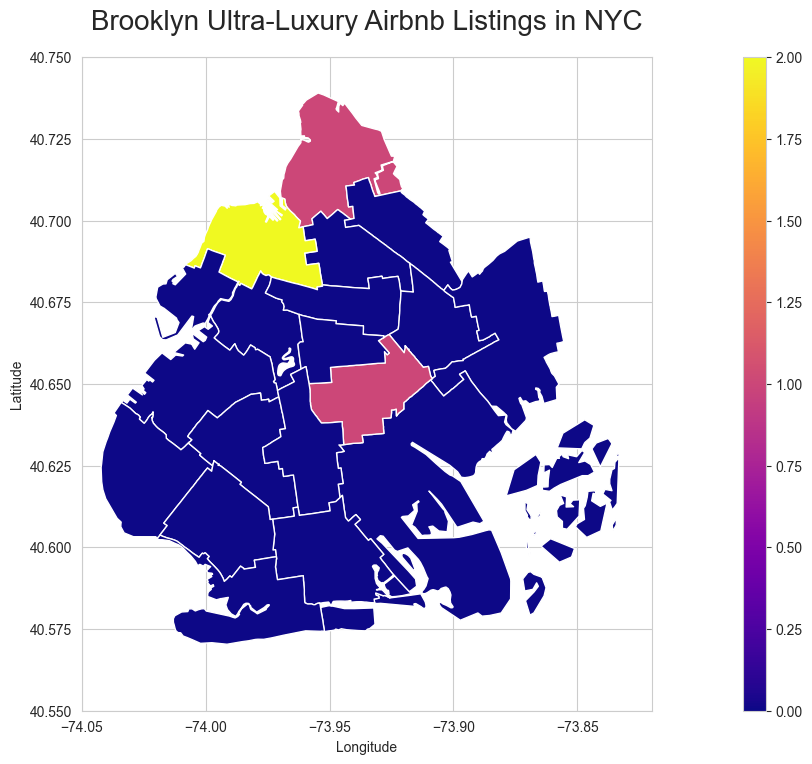

In [528]:
# Preparing the data
brooklyn_ultra_luxury_coordinates = airbnb_data.loc[airbnb_data['price'] > 5000, 
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(brooklyn_ultra_luxury_coordinates['longitude'], brooklyn_ultra_luxury_coordinates['latitude'])]
brooklyn_airbnb = gpd.GeoDataFrame(brooklyn_ultra_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
ultra_luxury_listings_in_brooklyn = gpd.sjoin(brooklyn_airbnb, brooklyn_map, how='inner')
ultra_luxury_listings_in_brooklyn = ultra_luxury_listings_in_brooklyn["index_right"].value_counts()
brooklyn_map.insert(loc=0, column='ultra_luxury_listings', value=ultra_luxury_listings_in_brooklyn)
brooklyn_map = brooklyn_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.82])  
ax.set_ylim([40.55, 40.75])
ax.set_title('Brooklyn Ultra-Luxury Airbnb Listings in NYC', 
             pad = 20, 
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
brooklyn_map.plot(ax=ax, cax=cax, cmap="plasma", column="ultra_luxury_listings", legend=True)

Text(0, 0.5, 'Number of Listings')

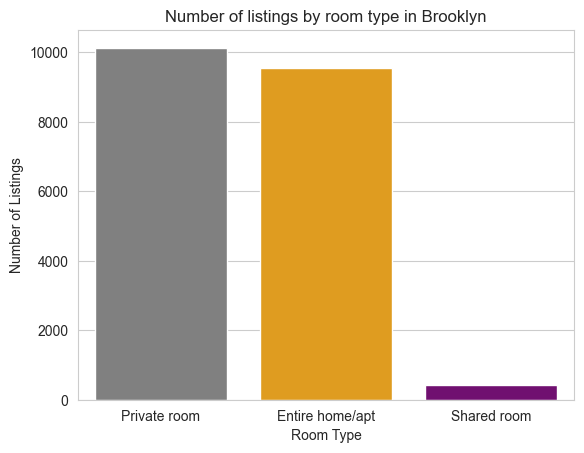

In [529]:
number_type_rooms_brooklyn = airbnb_data.loc[airbnb_data['borough'] == 'Brooklyn', 'room_type']
count_type_rooms_brooklyn = number_type_rooms_brooklyn.value_counts().reset_index()
count_type_rooms_brooklyn.columns = ['room_type', 'count']

sns.barplot(data=count_type_rooms_brooklyn, x='room_type', y='count', hue='room_type', palette=['grey', 'orange', 'purple'])
plt.title("Number of listings by room type in Brooklyn")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")

Text(0.5, 1.0, 'Prices by types of rooms in Brooklyn')

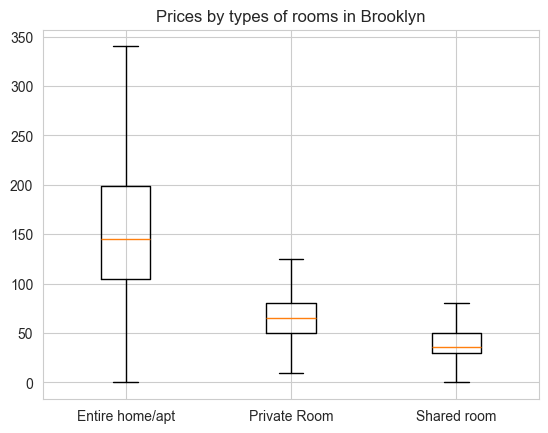

In [530]:
boxplot_homes_brooklyn = airbnb_data.loc[(airbnb_data['borough'] == 'Brooklyn') & (airbnb_data['room_type'] == 'Entire home/apt'), 'price']
boxplot_private_room_brooklyn = airbnb_data.loc[(airbnb_data['borough'] == 'Brooklyn') & (airbnb_data['room_type'] == 'Private room'), 'price']
boxplot_shared_room_brooklyn = airbnb_data.loc[(airbnb_data['borough'] == 'Brooklyn') & (airbnb_data['room_type'] == 'Shared room'), 'price']
plt.boxplot(x=[boxplot_homes_brooklyn, boxplot_private_room_brooklyn, boxplot_shared_room_brooklyn],
            labels=["Entire home/apt", "Private Room", "Shared room"], showfliers=False)
plt.title('Prices by types of rooms in Brooklyn')

<Axes: title={'center': 'Brooklyn Cheapest Entire Homes Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

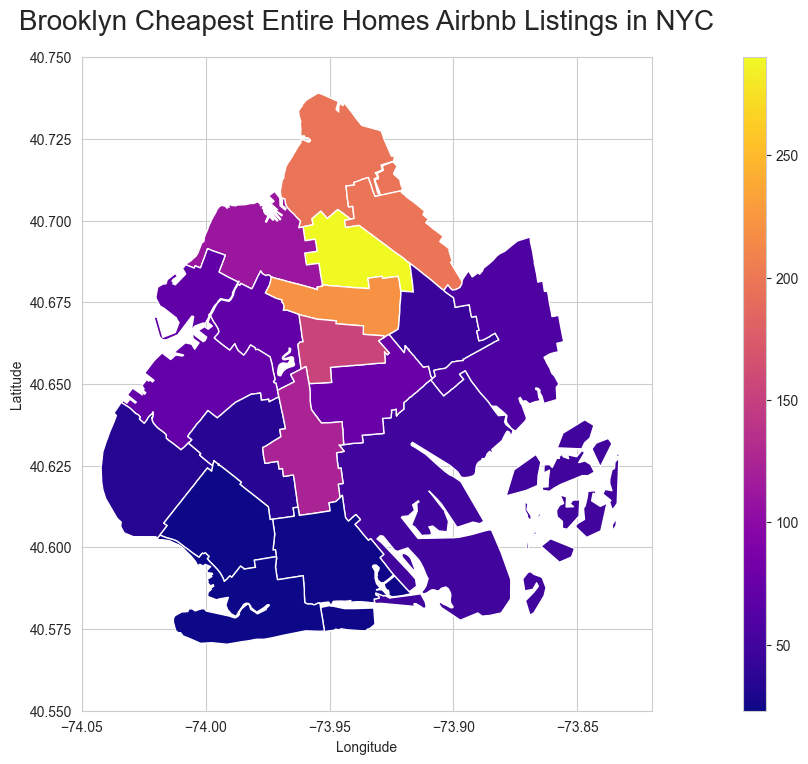

In [531]:
# Preparing the data
brooklyn_cheap_entire_apt_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Entire home/apt'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(brooklyn_cheap_entire_apt_coordinates['longitude'], brooklyn_cheap_entire_apt_coordinates['latitude'])]
brooklyn_cheap_entire_apt_airbnb = gpd.GeoDataFrame(brooklyn_cheap_entire_apt_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_entire_apt_listings_in_brooklyn = gpd.sjoin(brooklyn_cheap_entire_apt_airbnb, brooklyn_map, how='inner')
cheap_entire_apt_listings_in_brooklyn = cheap_entire_apt_listings_in_brooklyn["index_right"].value_counts()
brooklyn_map.insert(loc=0, column='cheap_entire_apt_listings', value=cheap_entire_apt_listings_in_brooklyn)
brooklyn_map = brooklyn_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.82])  
ax.set_ylim([40.55, 40.75])
ax.set_title('Brooklyn Cheapest Entire Homes Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
brooklyn_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_entire_apt_listings", legend=True)

<Axes: title={'center': 'Brooklyn Cheapest Private Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

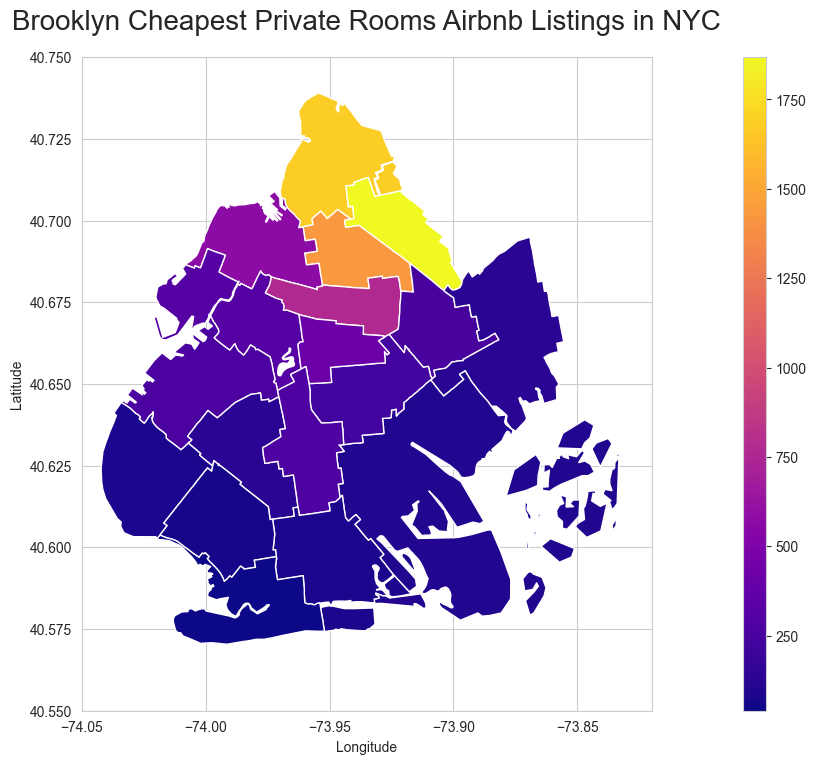

In [532]:
# Preparing the data
brooklyn_cheap_private_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(brooklyn_cheap_private_room_coordinates['longitude'], brooklyn_cheap_private_room_coordinates['latitude'])]
brooklyn_cheap_private_room_airbnb = gpd.GeoDataFrame(brooklyn_cheap_private_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_private_room_listings_in_brooklyn = gpd.sjoin(brooklyn_cheap_private_room_airbnb, brooklyn_map, how='inner')
cheap_private_room_listings_in_brooklyn = cheap_private_room_listings_in_brooklyn["index_right"].value_counts()
brooklyn_map.insert(loc=0, column='cheap_private_room_listings', value=cheap_private_room_listings_in_brooklyn)
brooklyn_map = brooklyn_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.82])
ax.set_ylim([40.55, 40.75])
ax.set_title('Brooklyn Cheapest Private Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
brooklyn_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_private_room_listings", legend=True)

<Axes: title={'center': 'Brooklyn Cheapest Shared Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

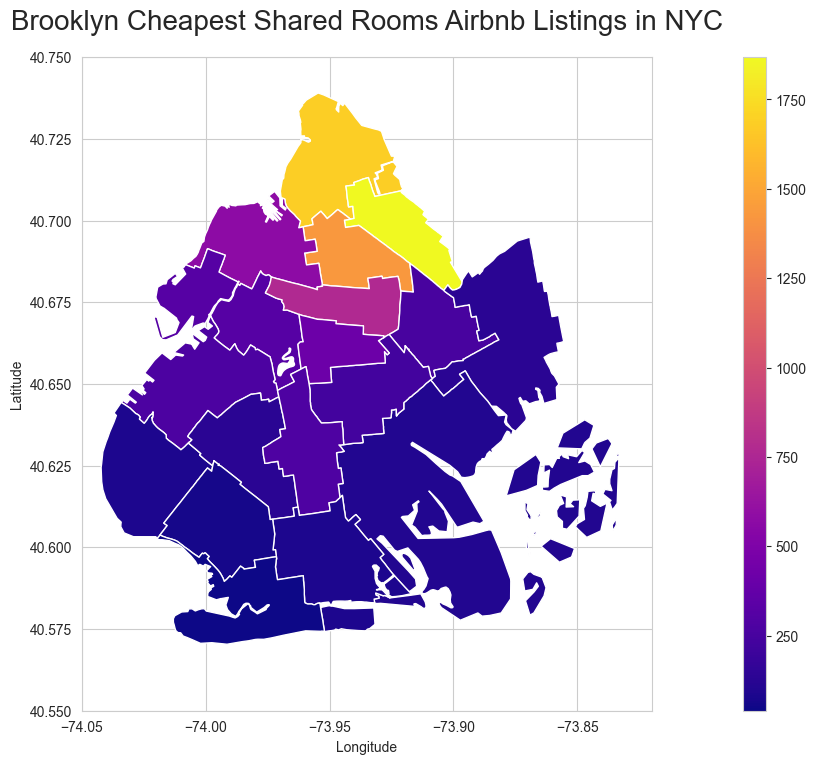

In [533]:
# Preparing the data
brooklyn_cheap_shared_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(brooklyn_cheap_shared_room_coordinates['longitude'], brooklyn_cheap_shared_room_coordinates['latitude'])]
brooklyn_shared_room_airbnb = gpd.GeoDataFrame(brooklyn_cheap_shared_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_shared_room_listings_in_brooklyn = gpd.sjoin(brooklyn_shared_room_airbnb, brooklyn_map, how='inner')
cheap_shared_room_listings_in_brooklyn = cheap_shared_room_listings_in_brooklyn["index_right"].value_counts()
brooklyn_map.insert(loc=0, column='cheap_shared_room_listings', value=cheap_shared_room_listings_in_brooklyn)
brooklyn_map = brooklyn_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.05, -73.82])
ax.set_ylim([40.55, 40.75])
ax.set_title('Brooklyn Cheapest Shared Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
brooklyn_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_shared_room_listings", legend=True)


#### BRONX ANALYSIS

In [534]:
# Prepare the map
bronx_map = nyc_map[nyc_map['borough'] == "Bronx"].to_crs(epsg=4326)
bronx_map.drop(['borough', 'code', 'borough_listings'], axis=1, inplace=True)

<Axes: title={'center': 'Bronx Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

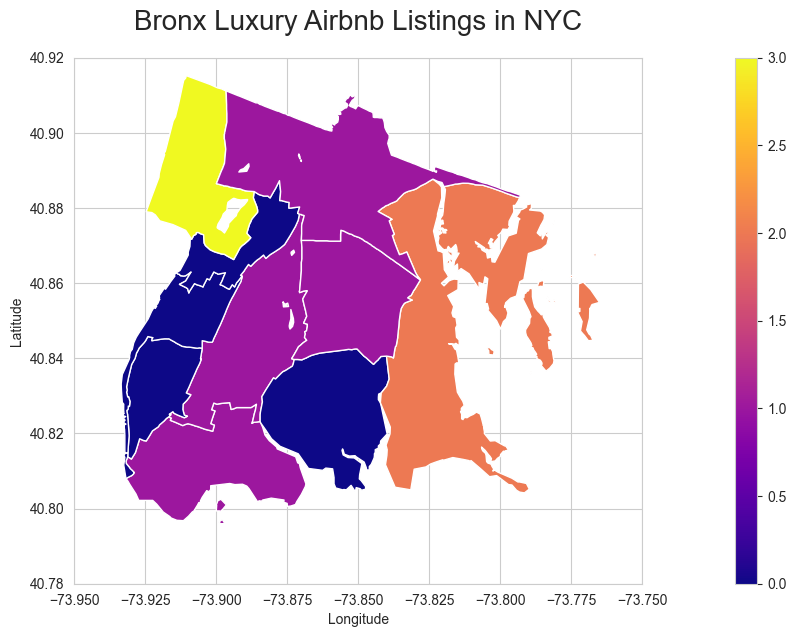

In [535]:
# Preparing the data
bronx_luxury_coordinates = airbnb_data.loc[(airbnb_data['price'] >= 500) & (airbnb_data['price'] <= 5000),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(bronx_luxury_coordinates['longitude'], bronx_luxury_coordinates['latitude'])]
bronx_airbnb = gpd.GeoDataFrame(bronx_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
luxury_listings_in_bronx = gpd.sjoin(bronx_airbnb, bronx_map, how='inner')
luxury_listings_in_bronx = luxury_listings_in_bronx["index_right"].value_counts()
bronx_map.insert(loc=0, column='luxury_listings', value=luxury_listings_in_bronx)
bronx_map = bronx_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-73.95, -73.75])
ax.set_ylim([40.78, 40.92])
ax.set_title('Bronx Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
bronx_map.plot(ax=ax, cax=cax, cmap="plasma", column="luxury_listings", legend=True)

<Axes: title={'center': 'Bronx Ultra-Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

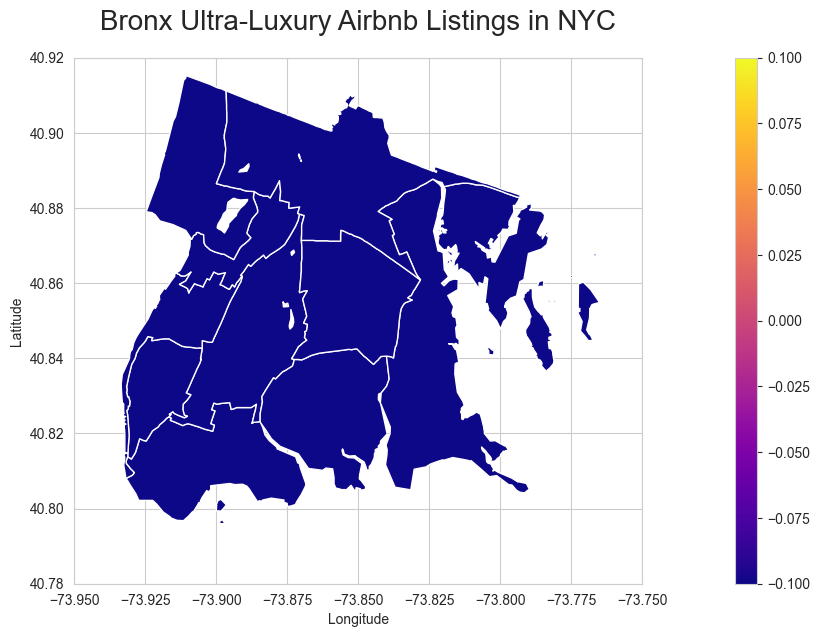

In [536]:
# Preparing the data
bronx_ultra_luxury_coordinates = airbnb_data.loc[airbnb_data['price'] > 5000,
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(bronx_ultra_luxury_coordinates['longitude'], bronx_ultra_luxury_coordinates['latitude'])]
bronx_airbnb = gpd.GeoDataFrame(bronx_ultra_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
luxury_ultra_listings_in_bronx = gpd.sjoin(bronx_airbnb, bronx_map, how='inner')
luxury_ultra_listings_in_bronx = luxury_ultra_listings_in_bronx["index_right"].value_counts()
bronx_map.insert(loc=0, column='ultra_luxury_listings', value=luxury_ultra_listings_in_bronx)
bronx_map = bronx_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-73.95, -73.75])
ax.set_ylim([40.78, 40.92])
ax.set_title('Bronx Ultra-Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
bronx_map.plot(ax=ax, cax=cax, cmap="plasma", column="ultra_luxury_listings", legend=True)

Text(0, 0.5, 'Number of Listings')

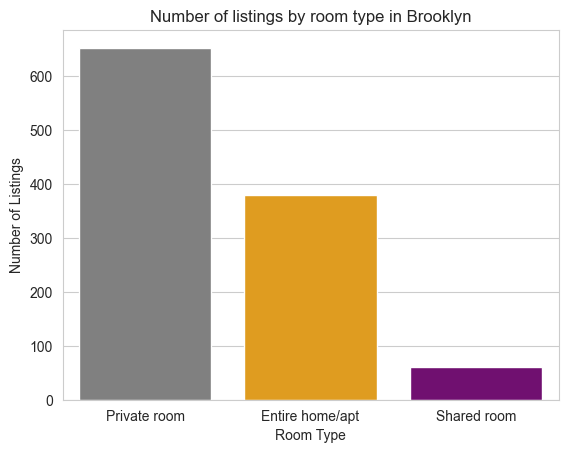

In [537]:
number_type_rooms_bronx = airbnb_data.loc[airbnb_data['borough'] == 'Bronx', 'room_type']
count_type_rooms_bronx = number_type_rooms_bronx.value_counts().reset_index()
count_type_rooms_bronx.columns = ['room_type', 'count']

sns.barplot(data=count_type_rooms_bronx, x='room_type', y='count', hue='room_type', palette=['grey', 'orange', 'purple'])
plt.title("Number of listings by room type in Brooklyn")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")

Text(0.5, 1.0, 'Prices by types of rooms in Bronx')

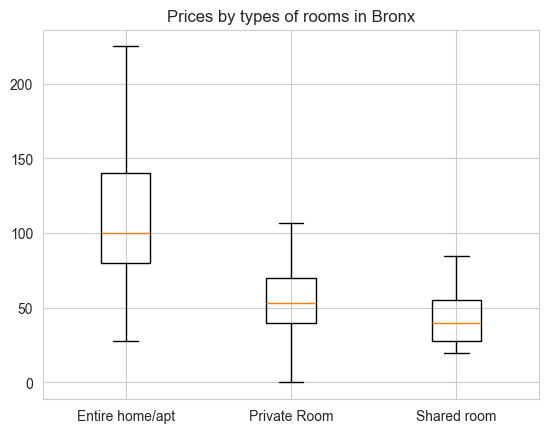

In [538]:
boxplot_homes_bronx = airbnb_data.loc[(airbnb_data['borough'] == 'Bronx') & (airbnb_data['room_type'] == 'Entire home/apt'), 'price']
boxplot_private_room_bronx = airbnb_data.loc[(airbnb_data['borough'] == 'Bronx') & (airbnb_data['room_type'] == 'Private room'), 'price']
boxplot_shared_room_bronx = airbnb_data.loc[(airbnb_data['borough'] == 'Bronx') & (airbnb_data['room_type'] == 'Shared room'), 'price']
plt.boxplot(x=[boxplot_homes_bronx, boxplot_private_room_bronx, boxplot_shared_room_bronx],
            labels=["Entire home/apt", "Private Room", "Shared room"], showfliers=False)
plt.title('Prices by types of rooms in Bronx')

<Axes: title={'center': 'Bronx Cheapest Entire Homes Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

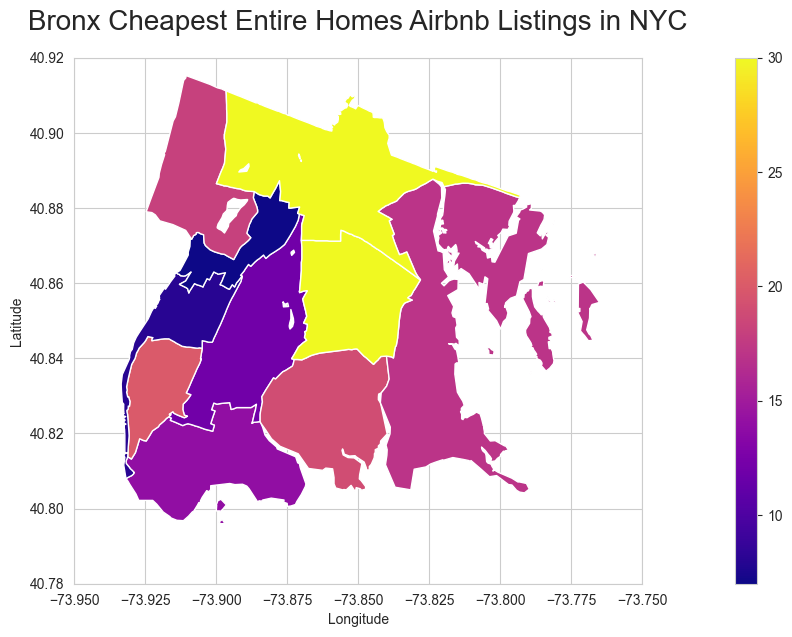

In [539]:
# Preparing the data
bronx_cheap_entire_apt_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Entire home/apt'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(bronx_cheap_entire_apt_coordinates['longitude'], bronx_cheap_entire_apt_coordinates['latitude'])]
bronx_cheap_entire_apt_airbnb = gpd.GeoDataFrame(bronx_cheap_entire_apt_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_entire_apt_listings_in_bronx = gpd.sjoin(bronx_cheap_entire_apt_airbnb, bronx_map, how='inner')
cheap_entire_apt_listings_in_bronx = cheap_entire_apt_listings_in_bronx["index_right"].value_counts()
bronx_map.insert(loc=0, column='cheap_entire_apt_listings', value=cheap_entire_apt_listings_in_bronx)
bronx_map = bronx_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-73.95, -73.75])
ax.set_ylim([40.78, 40.92])
ax.set_title('Bronx Cheapest Entire Homes Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
bronx_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_entire_apt_listings", legend=True)

<Axes: title={'center': 'Bronx Cheapest Private Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

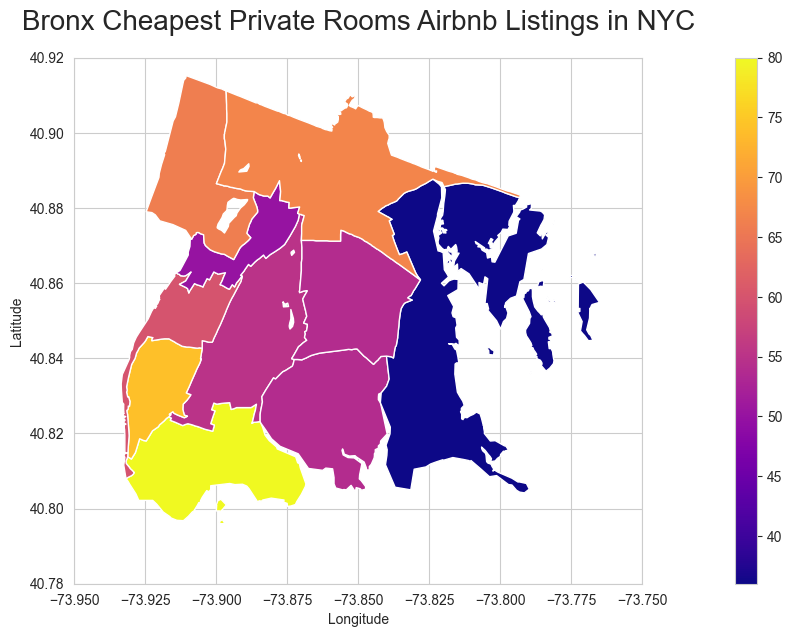

In [540]:
# Preparing the data
bronx_cheap_private_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(bronx_cheap_private_room_coordinates['longitude'], bronx_cheap_private_room_coordinates['latitude'])]
bronx_cheap_private_room_airbnb = gpd.GeoDataFrame(bronx_cheap_private_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_private_room_listings_in_bronx = gpd.sjoin(bronx_cheap_private_room_airbnb, bronx_map, how='inner')
cheap_private_room_listings_in_bronx = cheap_private_room_listings_in_bronx["index_right"].value_counts()
bronx_map.insert(loc=0, column='cheap_private_room_listings', value=cheap_private_room_listings_in_bronx)
bronx_map = bronx_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-73.95, -73.75])
ax.set_ylim([40.78, 40.92])
ax.set_title('Bronx Cheapest Private Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
bronx_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_private_room_listings", legend=True)

<Axes: title={'center': 'Bronx Cheapest Shared Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

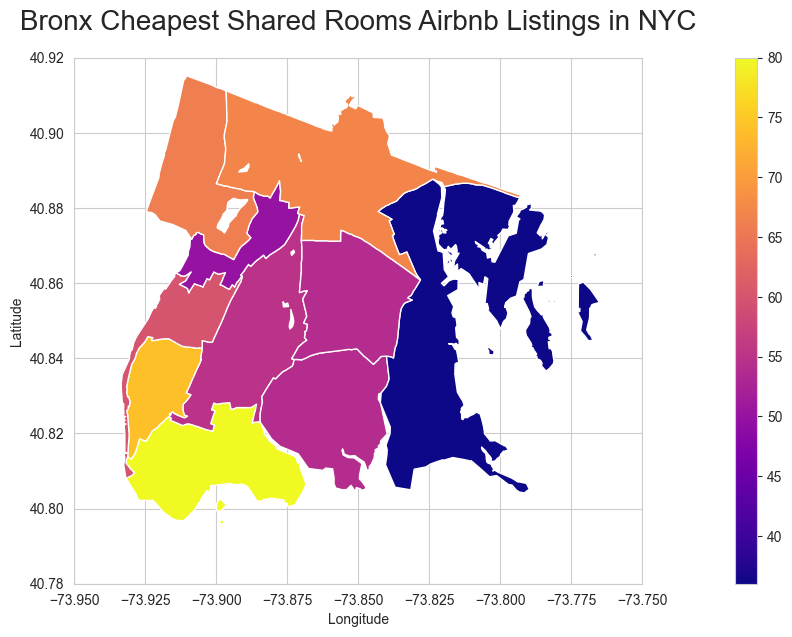

In [541]:
# Preparing the data
bronx_cheap_shared_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 100) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(bronx_cheap_shared_room_coordinates['longitude'], bronx_cheap_shared_room_coordinates['latitude'])]
bronx_cheap_shared_room_airbnb = gpd.GeoDataFrame(bronx_cheap_shared_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_shared_room_listings_in_bronx = gpd.sjoin(bronx_cheap_shared_room_airbnb, bronx_map, how='inner')
cheap_shared_room_listings_in_bronx = cheap_shared_room_listings_in_bronx["index_right"].value_counts()
bronx_map.insert(loc=0, column='cheap_shared_room_listings', value=cheap_shared_room_listings_in_bronx)
bronx_map = bronx_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-73.95, -73.75])
ax.set_ylim([40.78, 40.92])
ax.set_title('Bronx Cheapest Shared Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
bronx_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_shared_room_listings", legend=True)

#### QUEENS ANALYSIS

In [542]:
# Prepare the map
queens_map = nyc_map[nyc_map['borough'] == "Queens"].to_crs(epsg=4326)
queens_map.drop(['borough', 'code', 'borough_listings'], axis=1, inplace=True)

<Axes: title={'center': 'Queens Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

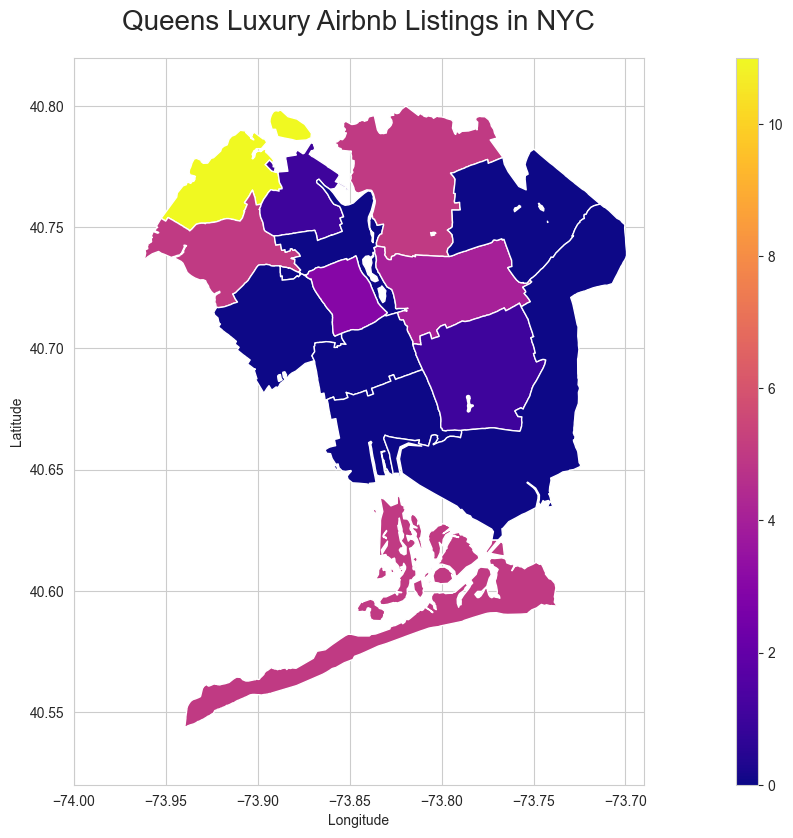

In [543]:
# Preparing the data
queens_luxury_coordinates = airbnb_data.loc[(airbnb_data['price'] >= 500) & (airbnb_data['price'] <= 5000),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(queens_luxury_coordinates['longitude'], queens_luxury_coordinates['latitude'])]
queens_airbnb = gpd.GeoDataFrame(queens_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
luxury_listings_in_queens = gpd.sjoin(queens_airbnb, queens_map, how='inner')
luxury_listings_in_queens = luxury_listings_in_queens["index_right"].value_counts()
queens_map.insert(loc=0, column='luxury_listings', value=luxury_listings_in_queens)
queens_map = queens_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74, -73.69])
ax.set_ylim([40.52, 40.82])
ax.set_title('Queens Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
queens_map.plot(ax=ax, cax=cax, cmap="plasma", column="luxury_listings", legend=True)

<Axes: title={'center': 'Queens Ultra-Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

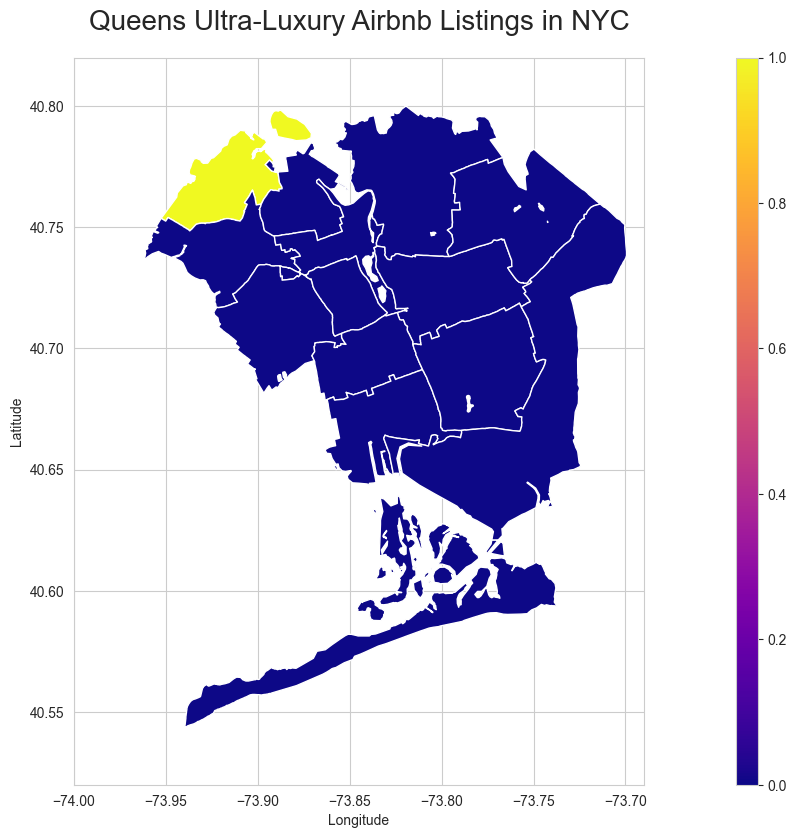

In [544]:
# Preparing the data
queens_ultra_luxury_coordinates = airbnb_data.loc[airbnb_data['price'] > 5000,
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(queens_ultra_luxury_coordinates['longitude'], queens_ultra_luxury_coordinates['latitude'])]
queens_airbnb = gpd.GeoDataFrame(queens_ultra_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
ultra_luxury_listings_in_queens = gpd.sjoin(queens_airbnb, queens_map, how='inner')
ultra_luxury_listings_in_queens = ultra_luxury_listings_in_queens["index_right"].value_counts()
queens_map.insert(loc=0, column='ultra_luxury_listings', value=ultra_luxury_listings_in_queens)
queens_map = queens_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74, -73.69])
ax.set_ylim([40.52, 40.82])
ax.set_title('Queens Ultra-Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
queens_map.plot(ax=ax, cax=cax, cmap="plasma", column="ultra_luxury_listings", legend=True)

Text(0, 0.5, 'Number of Listings')

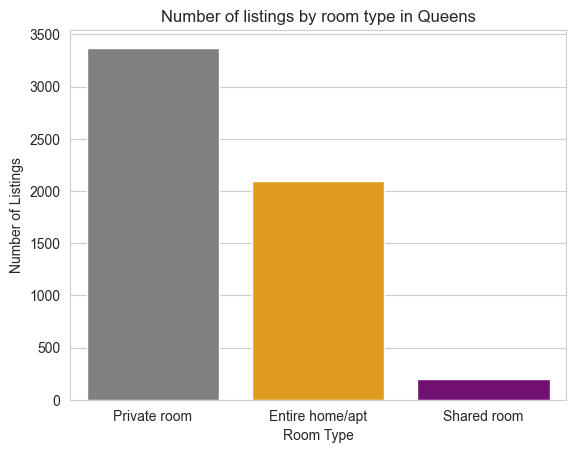

In [545]:
number_type_rooms_queens = airbnb_data.loc[airbnb_data['borough'] == 'Queens', 'room_type']
count_type_rooms_queens = number_type_rooms_queens.value_counts().reset_index()
count_type_rooms_queens.columns = ['room_type', 'count']

sns.barplot(data=count_type_rooms_queens, x='room_type', y='count', hue='room_type', palette=['grey', 'orange', 'purple'])
plt.title("Number of listings by room type in Queens")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")

Text(0.5, 1.0, 'Prices by types of rooms in Queens')

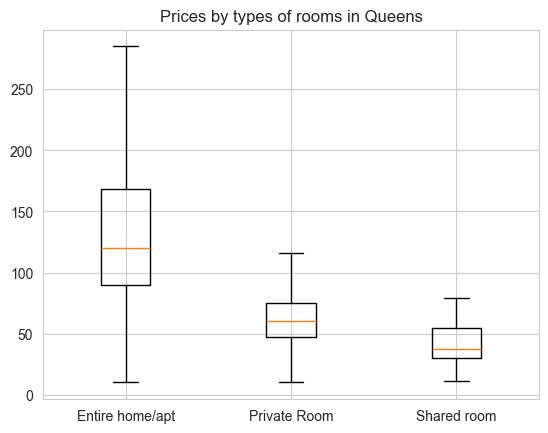

In [546]:
boxplot_homes_queens = airbnb_data.loc[(airbnb_data['borough'] == 'Queens') & (airbnb_data['room_type'] == 'Entire home/apt'), 'price']
boxplot_private_room_queens = airbnb_data.loc[(airbnb_data['borough'] == 'Queens') & (airbnb_data['room_type'] == 'Private room'), 'price']
boxplot_shared_room_queens = airbnb_data.loc[(airbnb_data['borough'] == 'Queens') & (airbnb_data['room_type'] == 'Shared room'), 'price']
plt.boxplot(x=[boxplot_homes_queens, boxplot_private_room_queens, boxplot_shared_room_queens],
            labels=["Entire home/apt", "Private Room", "Shared room"], showfliers=False)
plt.title('Prices by types of rooms in Queens')

<Axes: title={'center': 'Queens Cheapest Entire Homes Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

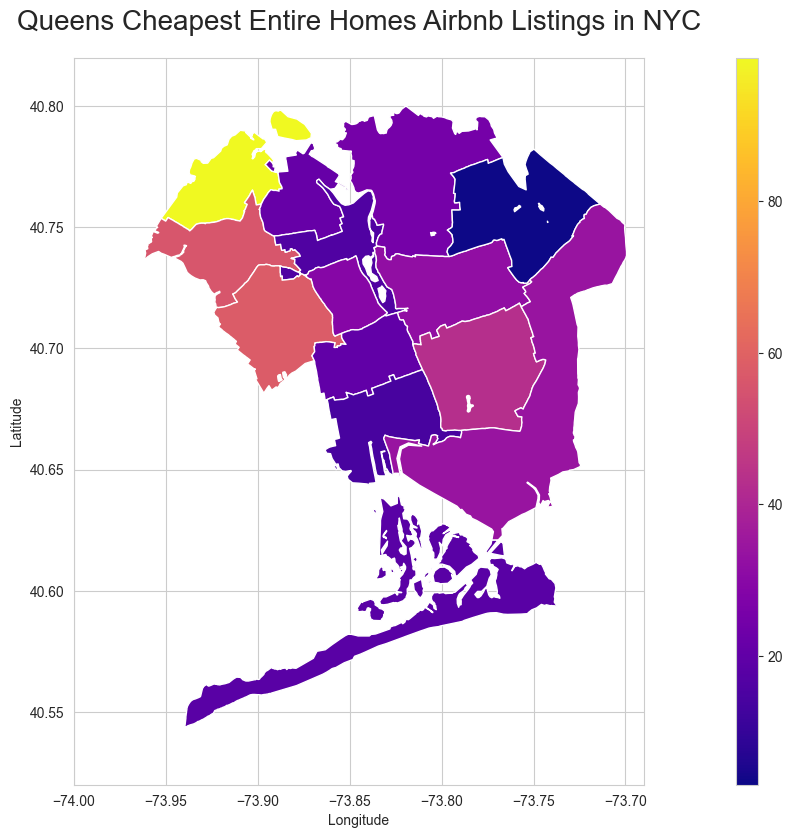

In [547]:
# Preparing the data
queens_cheap_entire_apt_coordinates = airbnb_data.loc[(airbnb_data['price'] < 90) & (airbnb_data['room_type'] == 'Entire home/apt'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(queens_cheap_entire_apt_coordinates['longitude'], queens_cheap_entire_apt_coordinates['latitude'])]
queens_cheap_entire_apt_airbnb = gpd.GeoDataFrame(queens_cheap_entire_apt_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_entire_apt_listings_in_queens = gpd.sjoin(queens_cheap_entire_apt_airbnb, queens_map, how='inner')
cheap_entire_apt_listings_in_queens = cheap_entire_apt_listings_in_queens["index_right"].value_counts()
queens_map.insert(loc=0, column='cheap_entire_apt_listings', value=cheap_entire_apt_listings_in_queens)
queens_map = queens_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74, -73.69])
ax.set_ylim([40.52, 40.82])
ax.set_title('Queens Cheapest Entire Homes Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
queens_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_entire_apt_listings", legend=True)

<Axes: title={'center': 'Queens Cheapest Private Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

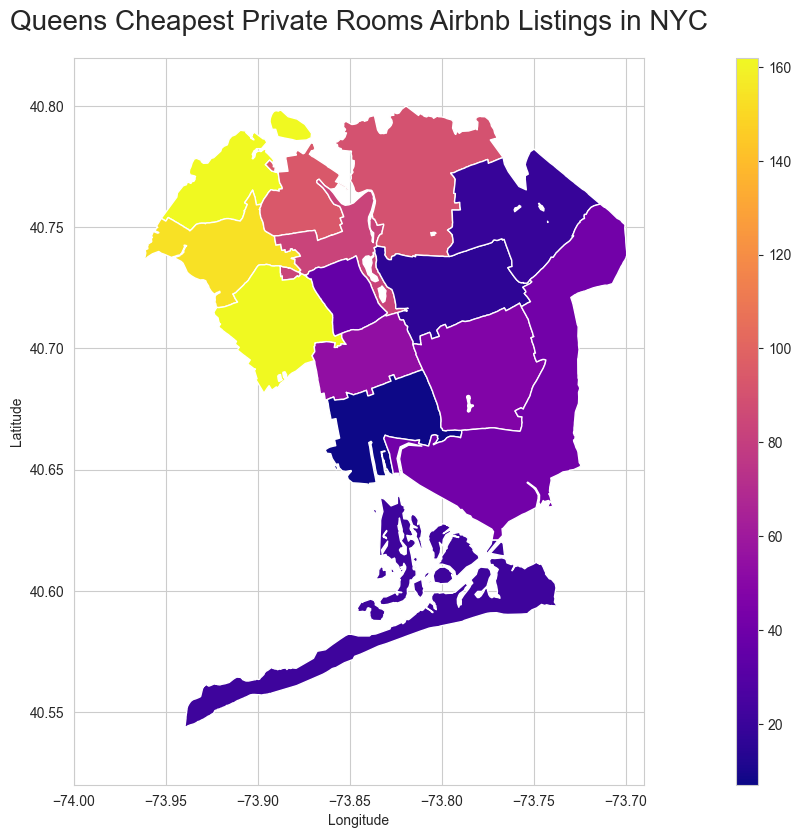

In [548]:
# Preparing the data
queens_cheap_private_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 50) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(queens_cheap_private_room_coordinates['longitude'], queens_cheap_private_room_coordinates['latitude'])]
queens_cheap_private_room_airbnb = gpd.GeoDataFrame(queens_cheap_private_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_private_room_listings_in_queens = gpd.sjoin(queens_cheap_private_room_airbnb, queens_map, how='inner')
cheap_private_room_listings_in_queens = cheap_private_room_listings_in_queens["index_right"].value_counts()
queens_map.insert(loc=0, column='cheap_private_room_listings', value=cheap_private_room_listings_in_queens)
queens_map = queens_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74, -73.69])
ax.set_ylim([40.52, 40.82])
ax.set_title('Queens Cheapest Private Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
queens_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_private_room_listings", legend=True)

<Axes: title={'center': 'Queens Cheapest Shared Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

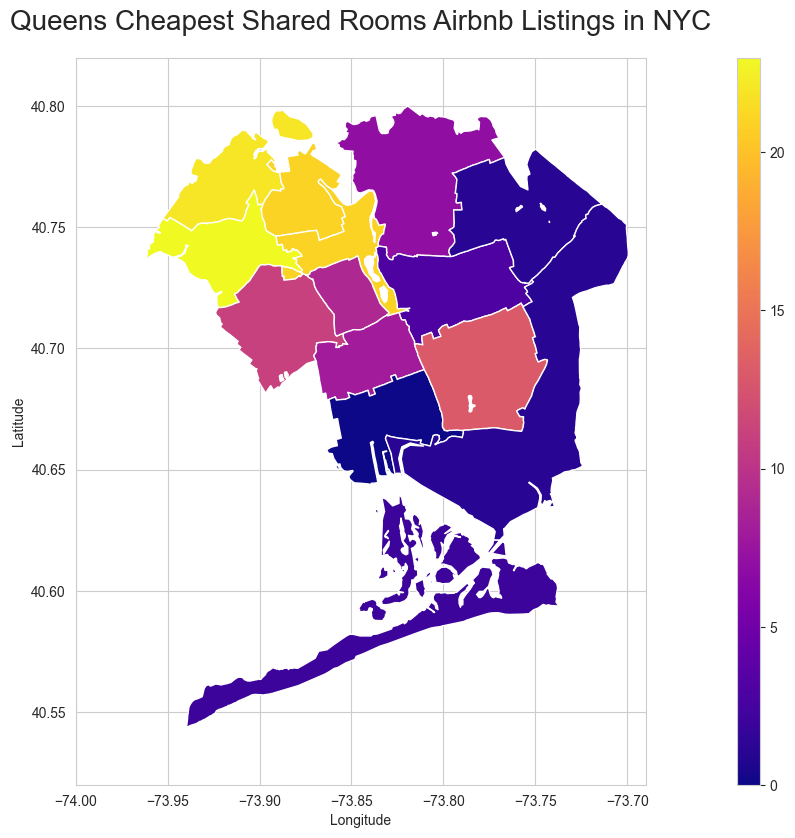

In [549]:
# Preparing the data
queens_cheap_shared_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 50) & (airbnb_data['room_type'] == 'Shared room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(queens_cheap_shared_room_coordinates['longitude'], queens_cheap_shared_room_coordinates['latitude'])]
queens_cheap_shared_room_airbnb = gpd.GeoDataFrame(queens_cheap_shared_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
cheap_shared_room_listings_in_queens = gpd.sjoin(queens_cheap_shared_room_airbnb, queens_map, how='inner')
cheap_shared_room_listings_in_queens = cheap_shared_room_listings_in_queens["index_right"].value_counts()
queens_map.insert(loc=0, column='cheap_shared_room_listings', value=cheap_shared_room_listings_in_queens)
queens_map = queens_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74, -73.69])
ax.set_ylim([40.52, 40.82])
ax.set_title('Queens Cheapest Shared Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
queens_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_shared_room_listings", legend=True)

### STATEN ISLAND ANALYSIS

In [550]:
# Prepare the map
staten_island_map = nyc_map[nyc_map['borough'] == "Staten Island"].to_crs(epsg=4326)
staten_island_map.drop(['borough', 'code', 'borough_listings'], axis=1, inplace=True)

<Axes: title={'center': 'Staten Island Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

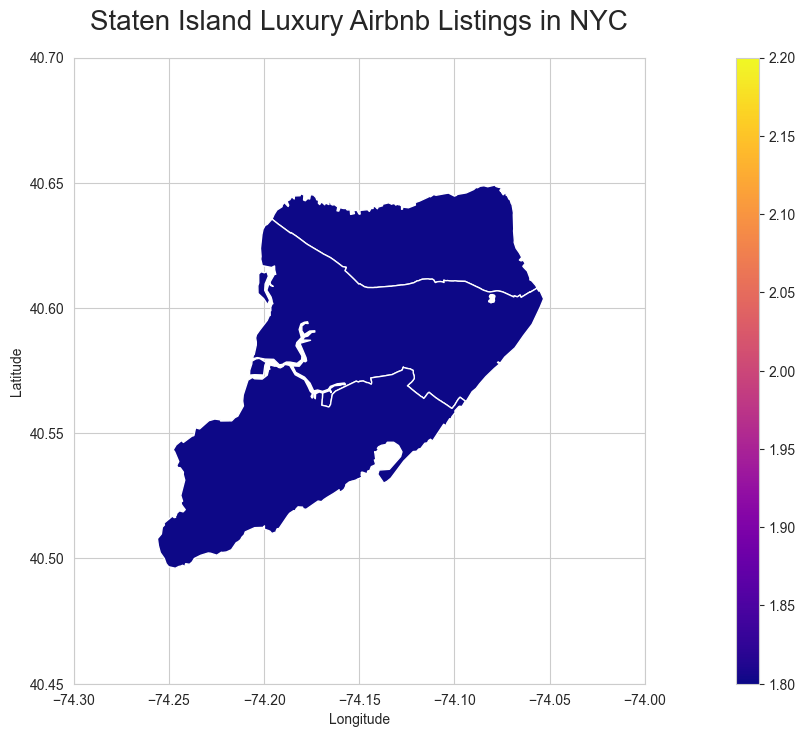

In [551]:
# Preparing the data
staten_island_luxury_coordinates = airbnb_data.loc[(airbnb_data['price'] >= 500) & (airbnb_data['price'] <= 5000),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(staten_island_luxury_coordinates['longitude'], staten_island_luxury_coordinates['latitude'])]
staten_island_airbnb = gpd.GeoDataFrame(staten_island_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
luxury_listings_in_staten_island = gpd.sjoin(staten_island_airbnb, staten_island_map, how='inner')
luxury_listings_in_staten_island = luxury_listings_in_staten_island["index_right"].value_counts()
staten_island_map.insert(loc=0, column='luxury_listings', value=luxury_listings_in_staten_island)
staten_island_map = staten_island_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.3, -74])
ax.set_ylim([40.45, 40.7])
ax.set_title('Staten Island Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
staten_island_map.plot(ax=ax, cax=cax, cmap="plasma", column="luxury_listings", legend=True)

<Axes: title={'center': 'Staten Island Ultra-Luxury Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

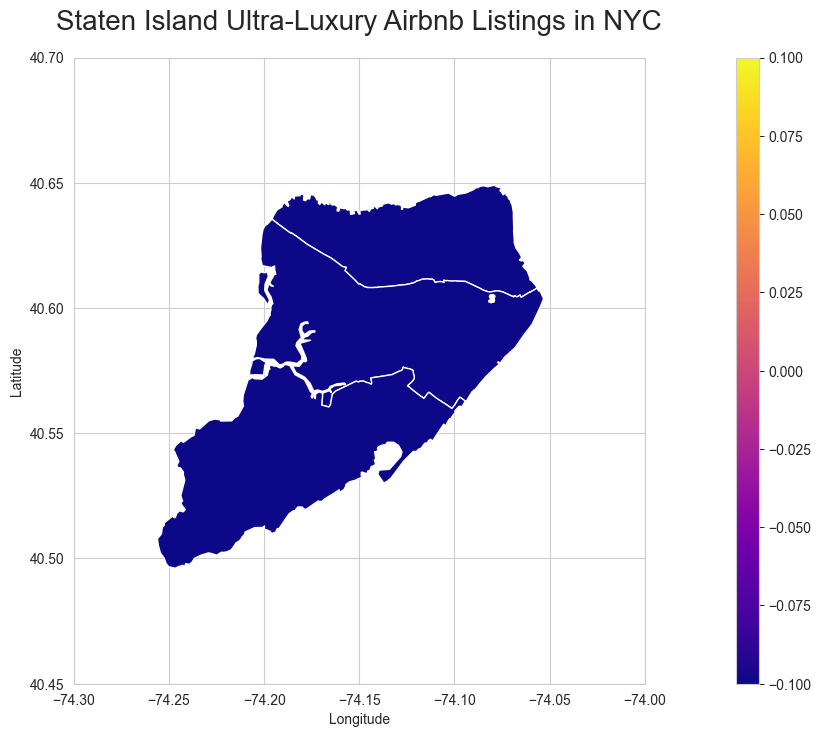

In [552]:
# Preparing the data
staten_island_ultra_luxury_coordinates = airbnb_data.loc[airbnb_data['price'] > 5000,
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(staten_island_ultra_luxury_coordinates['longitude'], staten_island_ultra_luxury_coordinates['latitude'])]
queens_airbnb = gpd.GeoDataFrame(staten_island_ultra_luxury_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
ultra_luxury_listings_in_staten_island = gpd.sjoin(queens_airbnb, staten_island_map, how='inner')
ultra_luxury_listings_in_staten_island = ultra_luxury_listings_in_staten_island["index_right"].value_counts()
staten_island_map.insert(loc=0, column='ultra_luxury_listings', value=ultra_luxury_listings_in_staten_island)
staten_island_map = staten_island_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.3, -74])
ax.set_ylim([40.45, 40.7])
ax.set_title('Staten Island Ultra-Luxury Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
staten_island_map.plot(ax=ax, cax=cax, cmap="plasma", column="ultra_luxury_listings", legend=True)

Text(0, 0.5, 'Number of Listings')

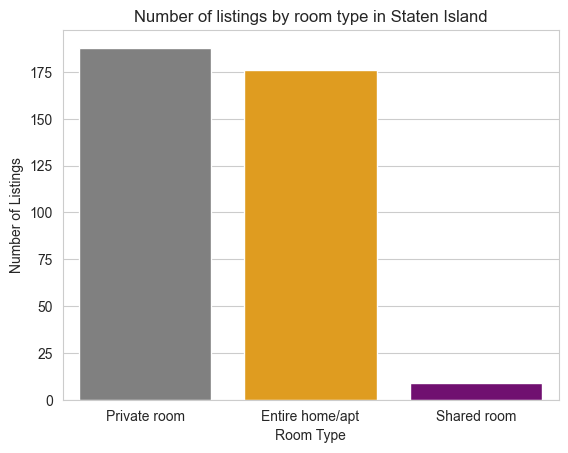

In [553]:
number_type_rooms_staten_island = airbnb_data.loc[airbnb_data['borough'] == 'Staten Island', 'room_type']
count_type_rooms_staten_island = number_type_rooms_staten_island.value_counts().reset_index()
count_type_rooms_staten_island.columns = ['room_type', 'count']

sns.barplot(data=count_type_rooms_staten_island, x='room_type', y='count', hue='room_type', palette=['grey', 'orange', 'purple'])
plt.title("Number of listings by room type in Staten Island")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")

Text(0.5, 1.0, 'Prices by types of rooms in Staten Island')

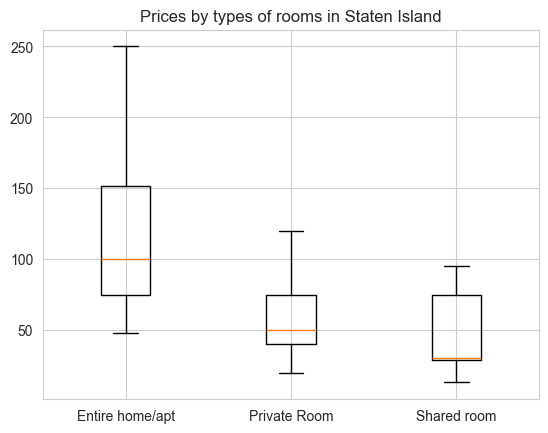

In [554]:
boxplot_homes_staten_island = airbnb_data.loc[(airbnb_data['borough'] == 'Staten Island') & (airbnb_data['room_type'] == 'Entire home/apt'), 'price']
boxplot_private_room_staten_island = airbnb_data.loc[(airbnb_data['borough'] == 'Staten Island') & (airbnb_data['room_type'] == 'Private room'), 'price']
boxplot_shared_room_staten_island = airbnb_data.loc[(airbnb_data['borough'] == 'Staten Island') & (airbnb_data['room_type'] == 'Shared room'), 'price']
plt.boxplot(x=[boxplot_homes_staten_island, boxplot_private_room_staten_island, boxplot_shared_room_staten_island],
            labels=["Entire home/apt", "Private Room", "Shared room"], showfliers=False)
plt.title('Prices by types of rooms in Staten Island')

<Axes: title={'center': 'Staten Island Cheapest Entire Homes Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

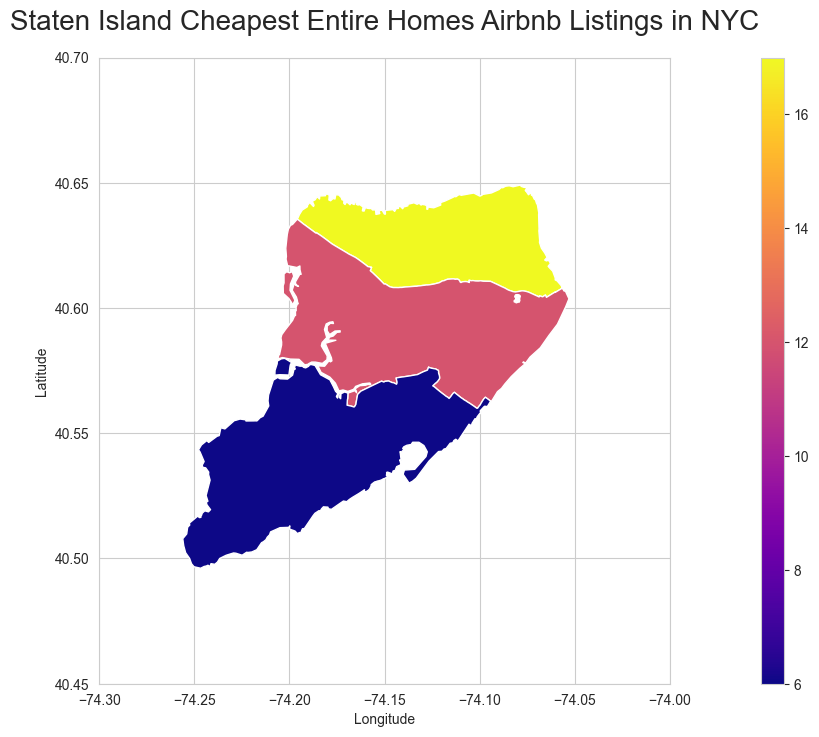

In [555]:
# Preparing the data
staten_island_cheap_entire_apt_coordinates = airbnb_data.loc[(airbnb_data['price'] < 75) & (airbnb_data['room_type'] == 'Entire home/apt'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(staten_island_cheap_entire_apt_coordinates['longitude'], staten_island_cheap_entire_apt_coordinates['latitude'])]
staten_island_cheap_entire_apt_airbnb = gpd.GeoDataFrame(staten_island_cheap_entire_apt_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
staten_island_entire_apt_listings_in_queens = gpd.sjoin(staten_island_cheap_entire_apt_airbnb, staten_island_map, how='inner')
staten_island_entire_apt_listings_in_queens = staten_island_entire_apt_listings_in_queens["index_right"].value_counts()
staten_island_map.insert(loc=0, column='cheap_entire_apt_listings', value=staten_island_entire_apt_listings_in_queens)
staten_island_map = staten_island_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.3, -74])
ax.set_ylim([40.45, 40.7])
ax.set_title('Staten Island Cheapest Entire Homes Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
staten_island_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_entire_apt_listings", legend=True)

<Axes: title={'center': 'Staten Island Cheapest Private Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

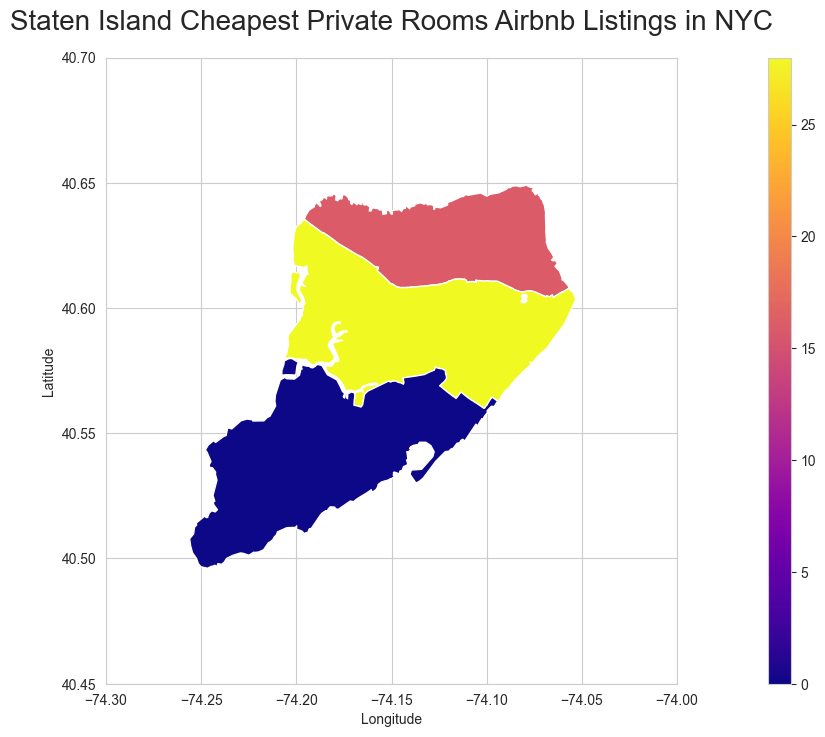

In [556]:
# Preparing the data
staten_island_cheap_private_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 40) & (airbnb_data['room_type'] == 'Private room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(staten_island_cheap_private_room_coordinates['longitude'], staten_island_cheap_private_room_coordinates['latitude'])]
staten_island_cheap_private_room_airbnb = gpd.GeoDataFrame(staten_island_cheap_private_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
staten_island_private_room_listings_in_queens = gpd.sjoin(staten_island_cheap_private_room_airbnb, staten_island_map, how='inner')
staten_island_private_room_listings_in_queens = staten_island_private_room_listings_in_queens["index_right"].value_counts()
staten_island_map.insert(loc=0, column='cheap_private_room_listings', value=staten_island_private_room_listings_in_queens)
staten_island_map = staten_island_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.3, -74])
ax.set_ylim([40.45, 40.7])
ax.set_title('Staten Island Cheapest Private Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
staten_island_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_private_room_listings", legend=True)

<Axes: title={'center': 'Staten Island Cheapest Shared Rooms Airbnb Listings in NYC'}, xlabel='Longitude', ylabel='Latitude'>

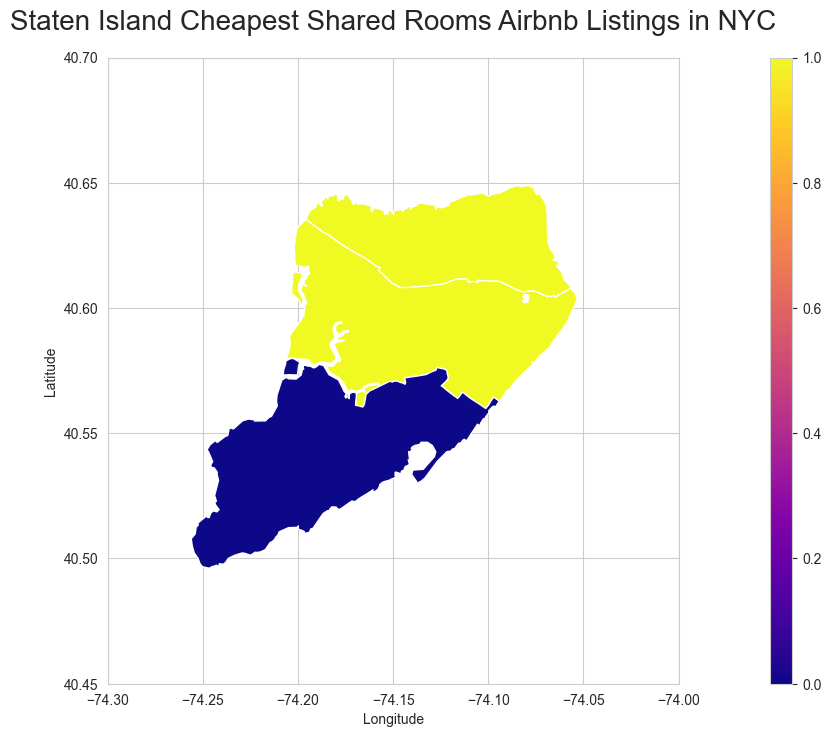

In [557]:
# Preparing the data
staten_island_cheap_shared_room_coordinates = airbnb_data.loc[(airbnb_data['price'] < 25) & (airbnb_data['room_type'] == 'Shared room'),
                                              ['latitude', 'longitude']]
geometry = [Point(xy) for xy in zip(staten_island_cheap_shared_room_coordinates['longitude'], staten_island_cheap_shared_room_coordinates['latitude'])]
staten_island_cheap_shared_room_airbnb = gpd.GeoDataFrame(staten_island_cheap_shared_room_coordinates, geometry=geometry).set_crs(epsg=4326, inplace=True)
staten_island_private_room_listings_in_queens = gpd.sjoin(staten_island_cheap_shared_room_airbnb, staten_island_map, how='inner')
staten_island_private_room_listings_in_queens = staten_island_private_room_listings_in_queens["index_right"].value_counts()
staten_island_map.insert(loc=0, column='cheap_shared_room_listings', value=staten_island_private_room_listings_in_queens)
staten_island_map = staten_island_map.fillna(0)

# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-74.3, -74])
ax.set_ylim([40.45, 40.7])
ax.set_title('Staten Island Cheapest Shared Rooms Airbnb Listings in NYC',
             pad = 20,
             fontdict={'fontsize':20})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.01)
staten_island_map.plot(ax=ax, cax=cax, cmap="plasma", column="cheap_shared_room_listings", legend=True)

# MACHINE LEARNING MODEL
This model aims to predict the prices of the listings 


Text(0.5, 1.0, 'Correlation Matrix')

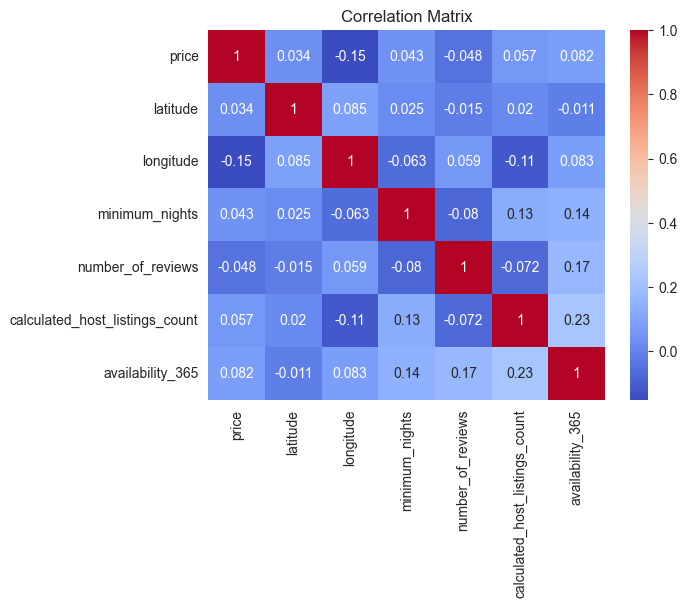

In [558]:
room_type_mapping = {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2
}
ML_data = airbnb_data
price_column = ML_data['price']
ML_data = ML_data.drop('price', axis=1)
ML_data.insert(0, 'price', price_column)
ML_data['room_type'] = ML_data['room_type'].map(room_type_mapping)
ML_data = ML_data.drop(['id', 'host_id', 'borough', 'sub-borough', 'room_type'], axis=1)
correlation_matrix = ML_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")

In [559]:
scaler = MinMaxScaler()
ML_data = scaler.fit_transform(ML_data)
y = ML_data[:, 0]
x = ML_data[:, 1:]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)

In [560]:
clf = LinearRegression()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"R^2 Score: {r2:.10f}")

Mean Squared Error (MSE): 0.0005260731
R^2 Score: 0.0441678561


In [561]:
clf = Ridge(alpha=1.0)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"R^2 Score: {r2:.10f}")

Mean Squared Error (MSE): 0.0005260755
R^2 Score: 0.0441634763


In [562]:
alpha_values = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, alpha_values, cv=5)
ridge_cv.fit(train_x, train_y)

print(f"Best alpha for Ridge: {ridge_cv.best_params_['alpha']}")

Best alpha for Ridge: 1


In [563]:
clf = Lasso(alpha=10)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"R^2 Score: {r2:.10f}")

Mean Squared Error (MSE): 0.0005503832
R^2 Score: -0.0000015141


As we can see, the best ML model is the Ridge Regression is the best one to predict the price of the listings based on the data we have. However, it is clear that the model it is not very good, the reason for that is the low correlation between the prices and the other variables, probably if we had data like how many bedrooms, how many rooms, square feet, etc. we would be able to create a much better model.